In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif

from os import listdir
from os.path import isfile, join

import cv2

In [2]:
# Chargement des fichiers csv dans une liste de dataframes

mypath='/Users/nicolasgonzalez/Projets/Projet 7/Fichiers_csv'
files = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]

df = np.empty(len(files), dtype=object)

for n in range(0, len(files)):
  df[n] = pd.read_csv(join(mypath,files[n]), encoding = 'unicode_escape')

print("Il y a {} fichiers dans le dossier".format(len(df)))


Il y a 10 fichiers dans le dossier


In [3]:
# Affichage des noms des fichiers

for i in range(len(df)):
    print("df[{}] contient le fichier: {}".format(i, files[i]))

df[0] contient le fichier: application_test.csv
df[1] contient le fichier: application_train.csv
df[2] contient le fichier: bureau.csv
df[3] contient le fichier: bureau_balance.csv
df[4] contient le fichier: credit_card_balance.csv
df[5] contient le fichier: HomeCredit_columns_description.csv
df[6] contient le fichier: installments_payments.csv
df[7] contient le fichier: POS_CASH_balance.csv
df[8] contient le fichier: previous_application.csv
df[9] contient le fichier: sample_submission.csv


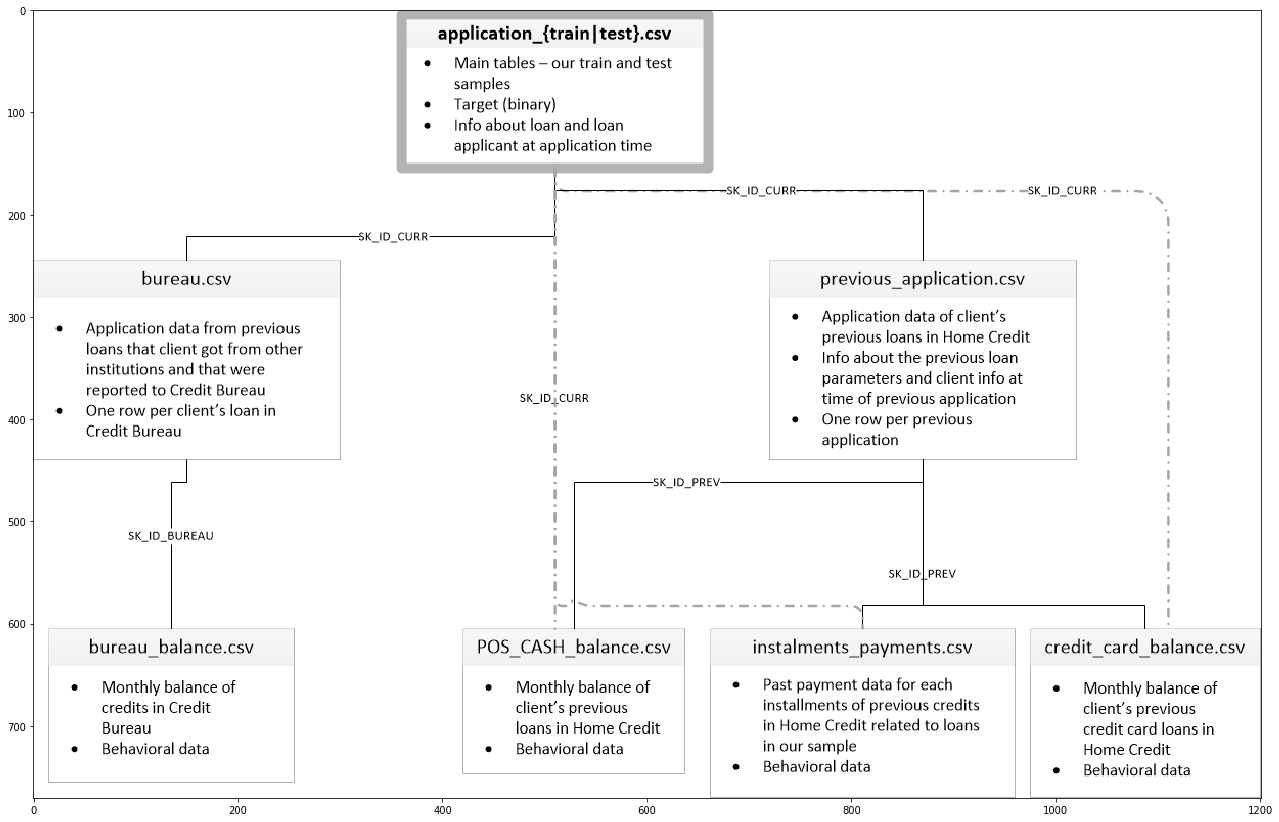

In [4]:
# Affichage de la structure de la base de données

img = cv2.imread("home_credit.png")
plt.figure(figsize=(22, 22))
plt.imshow(img)

# Sommaire

1. [Dataframe principal training & testing sets](#section1)
  1. [Création d'un dataframe regroupant training et test](#section1.1)
  2. [Analyse des Valeurs manquantes](#section1.2)
  3. [Traitement des outliers sur les variables qualitatives restant à analyser](#section1.3)
  4. [Analyse exploratoire](#section1.4)
  5. [Feature Engineering](#section1.5)
  
  
2. [Dataframes Bureau et Bureau_balance](#section2)
  1. [Dataframe Bureau](#section2.1)
  2. [Dataframe Bureau balance](#section2.2)


3. [Dataframe Previous Application](#section3)
  1. [Analyse des Valeurs manquantes](#section3.1)
  2. [Analyse exploratoire](#section3.2)
  3. [Feature Engineering](#section3.3)
  
  
4. [Dataframe instalments_payments et credit card balance](#section4)
  1. [Dataframe instalments_payments](#section4.1)
  2. [Dataframe credit card balance](#section4.2)
  
  
5. [Dataframe POS_CASH balance](#section5)
  1. [Analyse des Valeurs manquantes](#section5.1)
  2. [Feature Engineering](#section5.2)
  
  
6. [Sauvegarde du fichier pour modélisation](#section6)

<a id="section1"> </a>
# 1. Dataframe principal training & testing sets

In [5]:
# Analyse des tailles respectives

print("Taille du Df de training: {} \
    \n Taille du Df de testing: {}".format(df[1].shape, df[0].shape))

Taille du Df de training: (307511, 122)     
 Taille du Df de testing: (48744, 121)


La différence entre les 2 dataframes s'expliquent par la présence de la colonne TARGET qui représente ce que nous devons prédire (défaut ou pas sur un prêt). Je le vérifie rapidement.

In [6]:
df_test1 = df[1].drop("TARGET", axis = 1)

if len(df[0].columns) != len(df_test1.columns):
    print("Les df n'ont pas le même nombre de colonnes")
else:
    list_col = []
    for i in range(len(df[0].columns)):
        if df[0].columns[i] == df_test1.columns[i]:        
            list_col.append(1)
    if sum(list_col) != len(df[0].columns):
        print("Les df n'ont pas les mêmes colonnes")
    else:
        print("Good news les colonnes matchent entre les Df training et testing!!")

Good news les colonnes matchent entre les Df training et testing!!


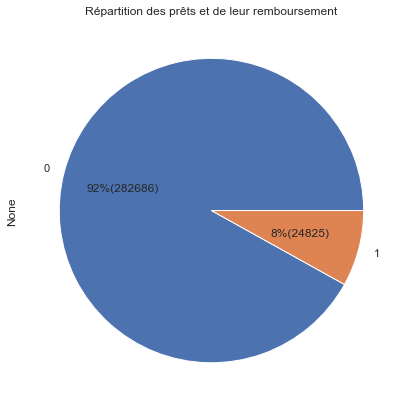

In [7]:
# Création de la variable contenant les prédictions de défaut pour entrainement du futur modèle et visualisation 
# de la distribution des prêts et de leur remboursement potentiel
# La valeur 0 indique un prêt remboursé, la valeur 1 un prêt non remboursé

y_train = df[1][["TARGET"]]

variable = y_train.groupby("TARGET").size()

sns.set()
variable.plot(kind='pie', 
              title='Répartition des prêts et de leur remboursement', 
              figsize=[7,7],
              autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*variable.sum()))
#plt.savefig("TypeSup1.png", dpi = 200)
plt.show()

La variable cible est clairement déséquilibrée, 92% des prêts ayant une valeur cible à zéro indiquant que les prêts de ces individus ont été remboursés à temps. Seulement 25000 prêts concernent des emprunteurs ayant eu des difficultés dans les remboursements.

<a id="section1.1"> </a>
## 1.A Création d'un dataframe regroupant training et test

Afin d'effectuer toute la partie de préparation des données une seule fois et surtout, considérer comme un seul jeu de données les parties test et training, je vais consolider les 2 dataframes en un seul.

In [8]:
# Avant cela, j'ajoute dans chaque Dataframe une colonne qui permettra d'isoler données de test et données 
# d'entrainement

df[0]["train_test"] = 'test'
df[1]["train_test"] = 'train'

In [9]:
# Je supprime ensuite la colonne Target que j'ai isolée dans une variable cible

train_X = df[1].drop("TARGET", axis = 1)

In [10]:
# Enfin je fusionne les deux dataframe

data = pd.concat([df[0], train_X], axis = 0)

In [11]:
# Vérification de la fusion
print("Taille du Df de training: {} \
    \n Taille du Df de testing: {} \
    \n Taille du Df consolidé: {}".format(train_X.shape, df[0].shape, data.shape))

Taille du Df de training: (307511, 122)     
 Taille du Df de testing: (48744, 122)     
 Taille du Df consolidé: (356255, 122)


<a id="section1.2"> </a>
## 1.B Analyse des Valeurs manquantes

In [12]:
# Nombre de colonnes ayant des valeurs manquantes

print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(data.isna().any()[lambda x: x]))

Nombre de colonnes ayant au moins 1 valeur manquante: 67


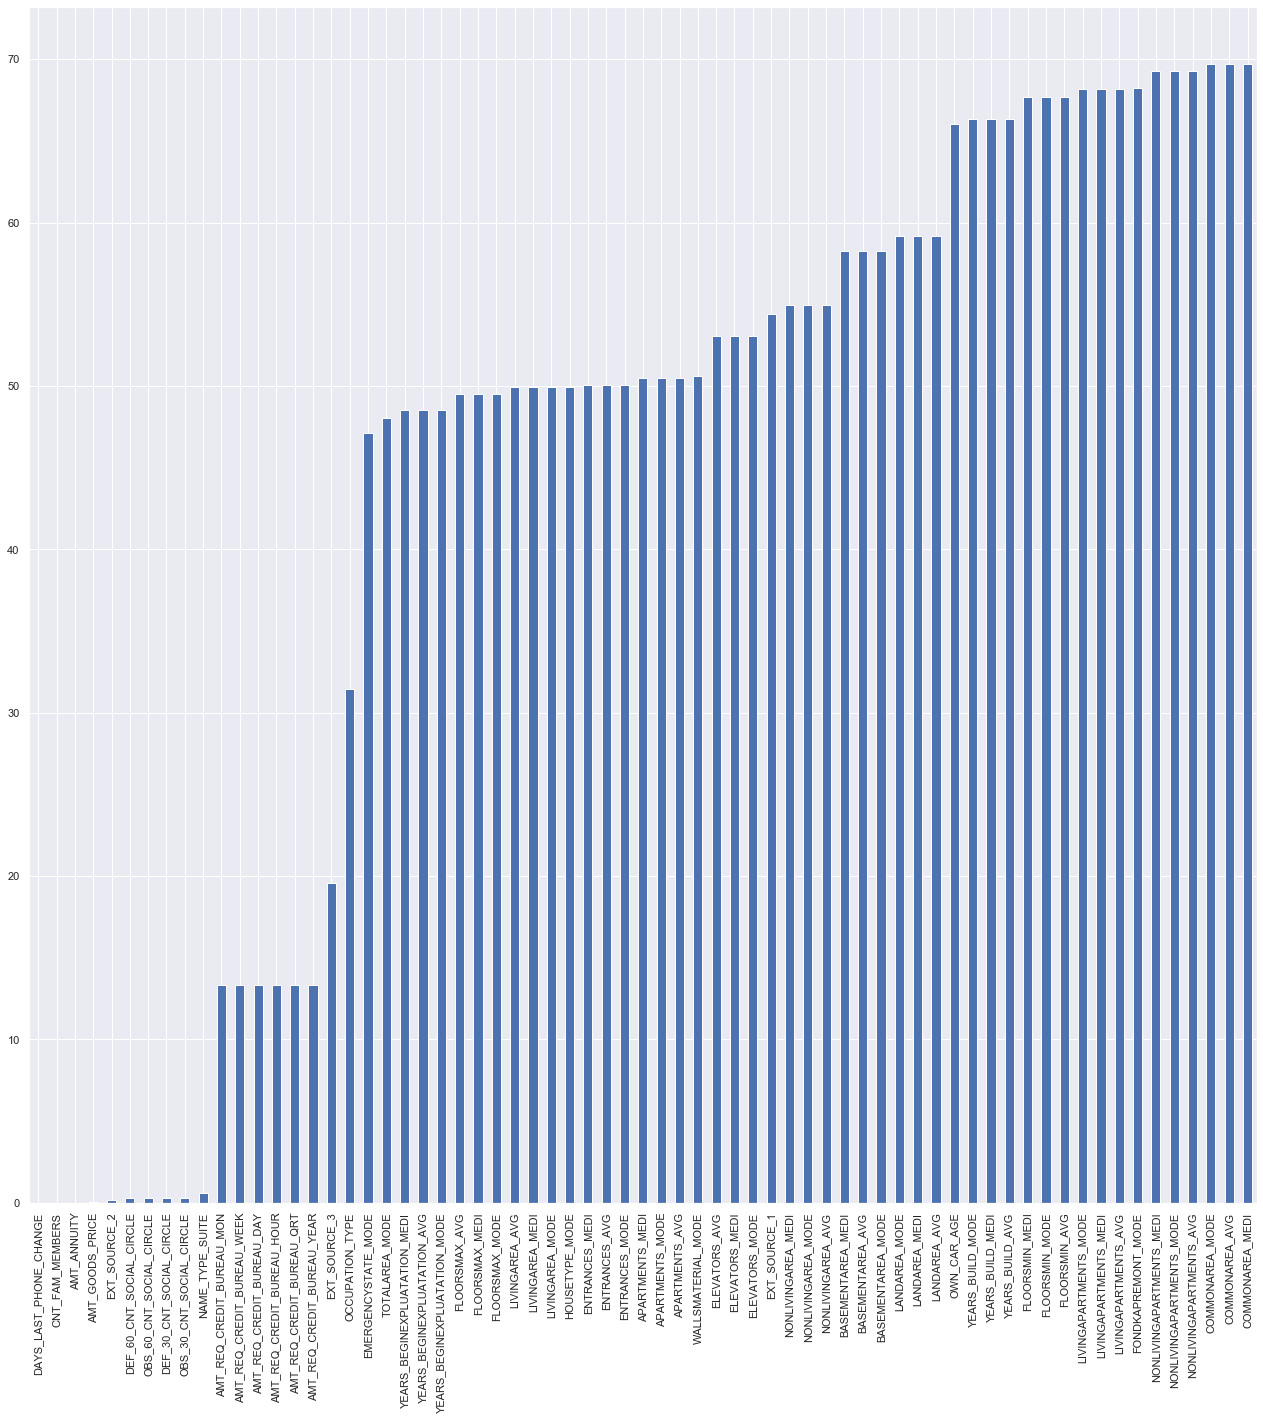

In [13]:
#Observation des pourcentages de valeurs manquantes par colonnes ayant des valeurs manquantes

nan_cols = [i for i in data.columns if data[i].isnull().any()]
percent_missing = data[nan_cols].isna().sum() * 100 / len(data)
plt.figure(figsize=(22, 22))
percent_missing.sort_values().plot(kind='bar')
plt.show()

In [14]:
# Cas des variables pour lesquelles il y a plus de 30% de valeurs manquantes

df_nan = percent_missing.sort_values(ascending = False).to_frame()
df_nan = df_nan.rename(columns = {0:'Prct'})
df_nan_30 = df_nan[df_nan["Prct"] > 30]
print("Il y a {} variables avec un taux de valeurs manquantes supérieur à 30%".format(len(df_nan_30)))

Il y a 50 variables avec un taux de valeurs manquantes supérieur à 30%


In [15]:
# Définitions de ces variables

list_DEF = []
for i in range(len(df_nan_30)):
    list_DEF.append(df[5][df[5].Row == df_nan_30.index[i]].Description.values)
    print("Variable {}: {}".format(df_nan_30.index[i], df[5][df[5].Row == df_nan_30.index[i]].Description.values))

Variable COMMONAREA_MEDI: ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']
Variable COMMONAREA_AVG: ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']
Variable COMMONAREA_MODE: ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']
Variable NONLIVINGAPARTMENTS_AVG: ['Normalized information about building where 

La plupart des définitions sont les mêmes, voici les valeurs uniques qui confirment qu'à part une variable liée à l'age du véhicule du client, une liée à l'activité pro du client et celle liée à un score, toutes sont liées à des données sur l'habitat des clients.

In [16]:
np.unique(list_DEF)

array(["Age of client's car",
       'Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor',
       'Normalized score from external data source',
       'What kind of occupation does the client have'], dtype=object)

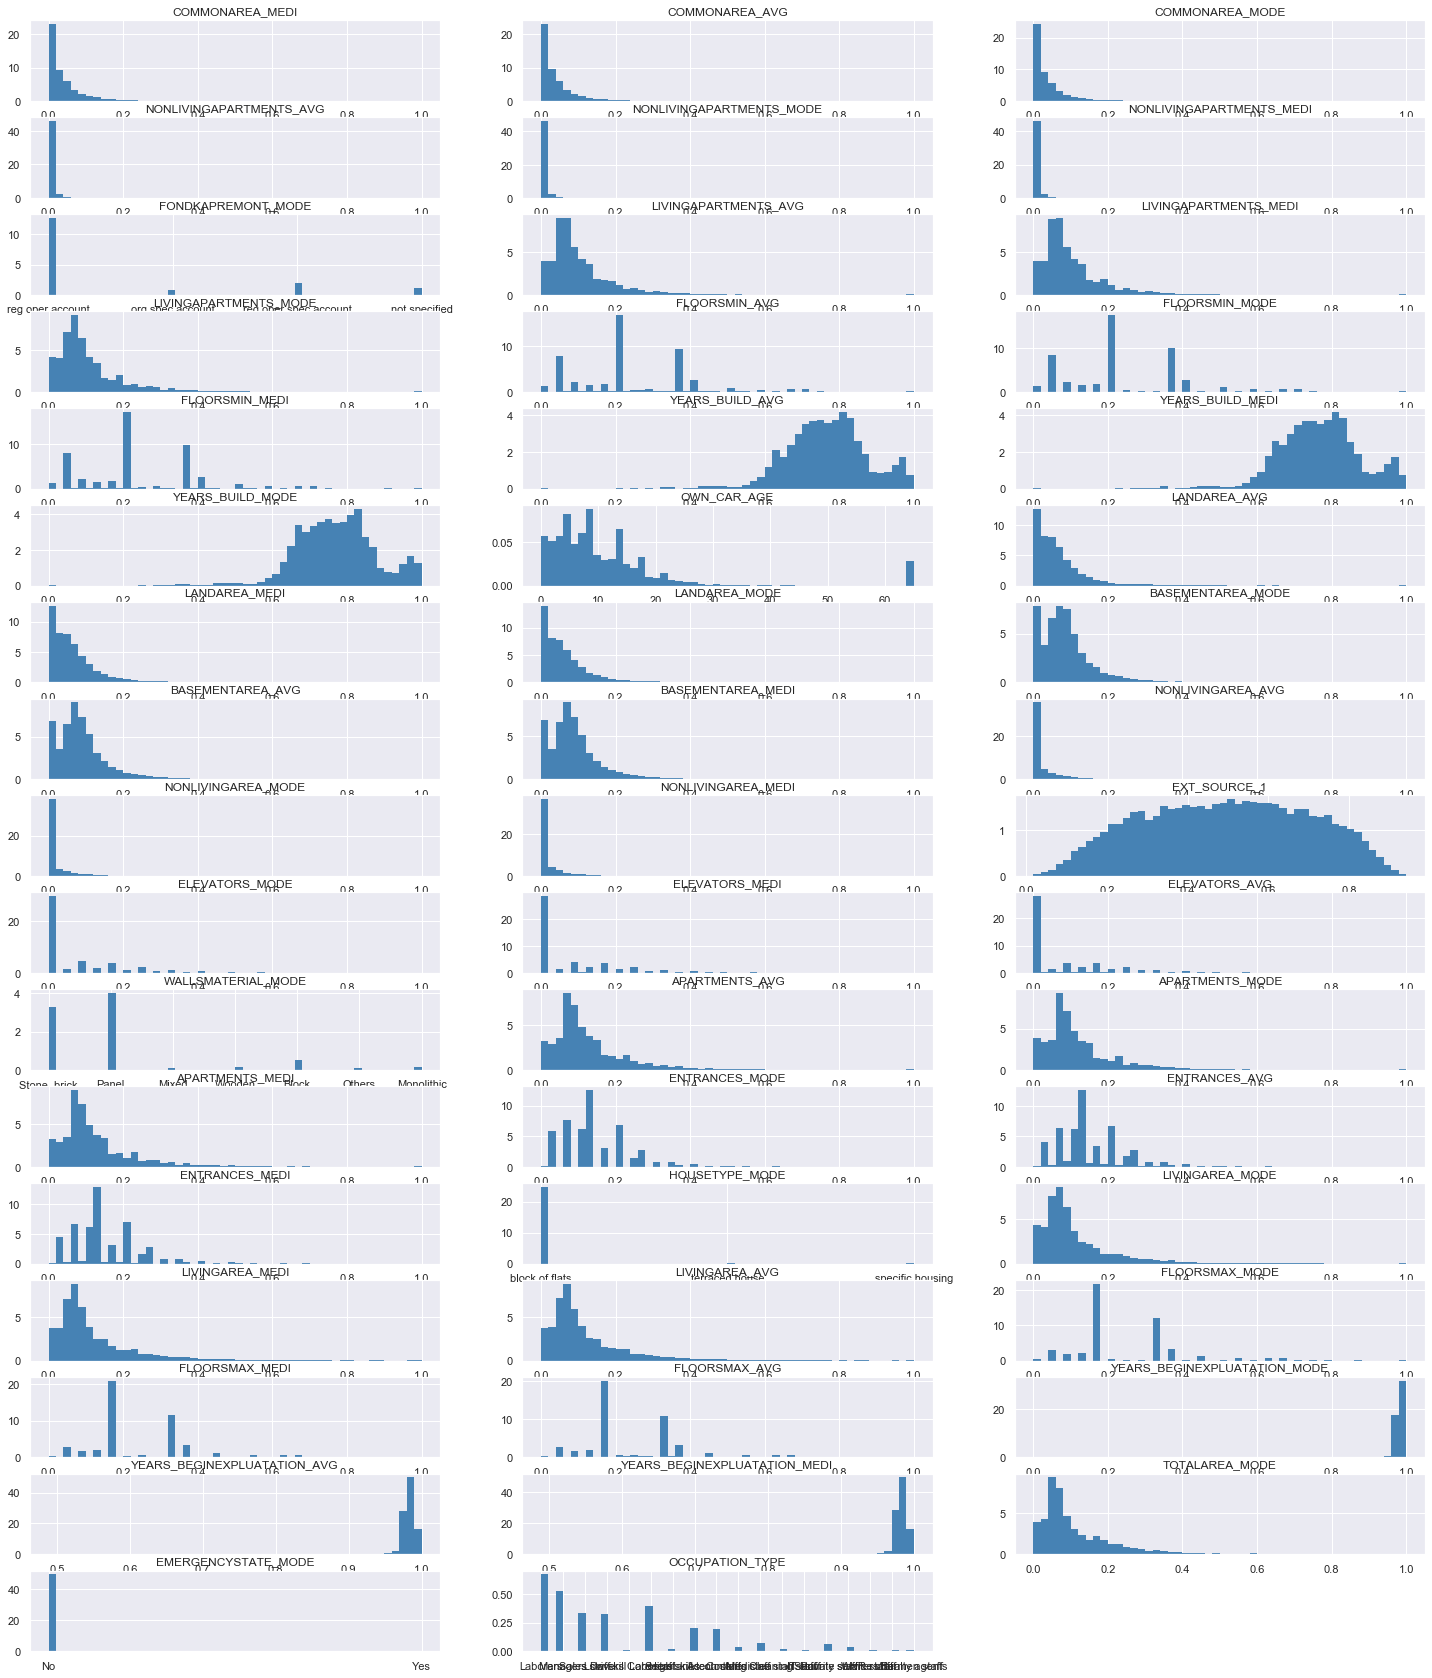

In [17]:
# Observons la distribution des valeurs de ces variables pour se faire une idée des ordres de grandeurs

X = data[df_nan_30.index].dropna().values

fig = plt.figure(figsize=(25, 30))

for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(17,3, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data[df_nan_30.index].columns[feat_idx], fontsize=12)

#plt.savefig("distri.png", dpi=250)

plt.show()

HYPOTHESE FEATURE ENGINEERING: je vais supprimer les variables liées à l'habitat des clients (sauf FONDKAPREMONT_MODE) et créer une variable "Living_info_prct" qui représentera le % de données liées à l'habitation que le client aura fournies.  
Cela permettra de voir si les personnes ne fournissant pas cette information n'ont pas une plus forte probabilité de défaut.

Pour cela je vais créer une liste de colonnes liées à l'habitation pour lesquelles:  
- je vais remplacer les valeurs numériques déja renseignées par zéro
- je vais remplacer les valeurs manquantes par 1
- je vais créer une colonne "Living_info_prct" dont chaque valeur sera égale à 1 - la somme des valeurs de ces colonnes divisée par le nombre total de colonnes

In [18]:
cols_to_delete = ['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_AVG',
                  'NONLIVINGAPARTMENTS_MODE','NONLIVINGAPARTMENTS_MEDI','LIVINGAPARTMENTS_AVG',
                  'LIVINGAPARTMENTS_MEDI','LIVINGAPARTMENTS_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI','FLOORSMIN_MODE',
                  'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI','YEARS_BUILD_MODE', 'LANDAREA_AVG','LANDAREA_MEDI',
                  'LANDAREA_MODE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG','BASEMENTAREA_MEDI', 'NONLIVINGAREA_AVG',
                  'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MODE','ELEVATORS_MEDI', 'ELEVATORS_AVG',
                  'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'APARTMENTS_AVG','ENTRANCES_MODE', 'ENTRANCES_AVG', 
                  'ENTRANCES_MEDI', 'LIVINGAREA_MEDI','LIVINGAREA_MODE', 'LIVINGAREA_AVG','WALLSMATERIAL_MODE',
                  'HOUSETYPE_MODE', 'FLOORSMAX_MODE','FLOORSMAX_MEDI', 'FLOORSMAX_AVG', 
                  'YEARS_BEGINEXPLUATATION_MEDI','YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG',
                  'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE']
print("Il y a {} colonnes liées à l'habitat à supprimer".format(len(cols_to_delete)))

Il y a 46 colonnes liées à l'habitat à supprimer


In [19]:
data[cols_to_delete] = np.where(data[cols_to_delete].isnull(),1,0)
data["Living_info_prct"] = 1 - data[cols_to_delete].astype(float).sum(1)/len(cols_to_delete)

In [20]:
# Confirmation qu'il ne reste plus que 67 - 46 colonnes ayant des valeurs manquantes

print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(data.isna().any()[lambda x: x]))

Nombre de colonnes ayant au moins 1 valeur manquante: 21


In [21]:
# Je supprime du Dataframe les 46 colonnes sur lesquelles nous venons de travailler

data = data.drop(cols_to_delete, axis = 1)

Je m'intéresse désormais aux 4 variables restantes pour lesquelles le % de valeurs manquantes est supérieur à 30%:  
'FONDKAPREMONT_MODE'  
'OWN_CAR_AGE'  
'EXT_SOURCE_1'  
'OCCUPATION_TYPE'

In [22]:
# La première variable ayant parmi ses valeurs 'Not Specified', je vais remplacer les NaN par cette valeur

data.FONDKAPREMONT_MODE = data.FONDKAPREMONT_MODE.fillna('not specified')
data.FONDKAPREMONT_MODE.unique()

array(['not specified', 'reg oper account', 'org spec account',
       'reg oper spec account'], dtype=object)

Passons à 'OWN_CAR_AGE'

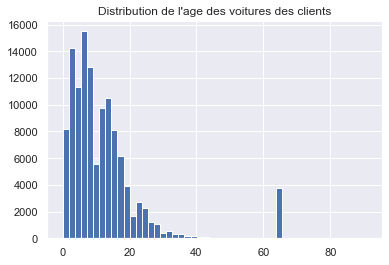

In [23]:
# Visualisation de la distribution de la variable

data.hist("OWN_CAR_AGE", bins=50)

plt.title("Distribution de l'age des voitures des clients")
#plt.savefig("age.png", dpi = 200)
plt.show()

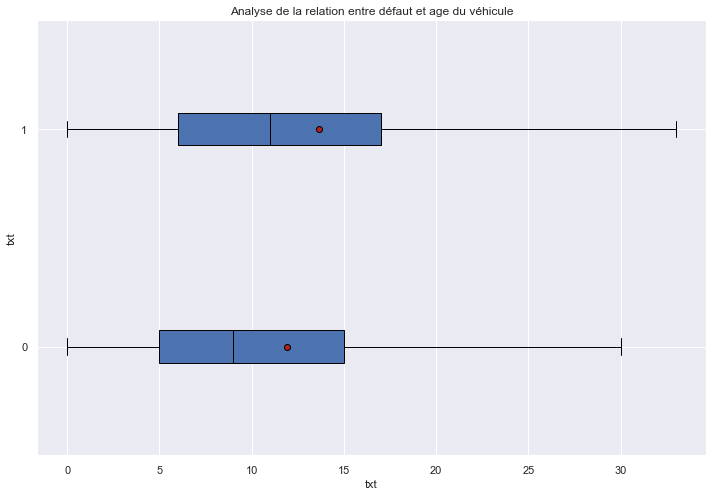

In [24]:
# Etude du lien entre age de la voiture et défaut de prêt ou non (training set)

#Création d'un dataframe sans valeurs manquantes
df_age_def = df[1][["OWN_CAR_AGE", "TARGET"]].dropna()

#Représentation graphique de la relation entre défaut et age de voiture
modalites = np.sort(df_age_def.TARGET.unique())
groupes = []

for m in modalites:
    groupes.append(df_age_def[df_age_def["TARGET"] == m]["OWN_CAR_AGE"])

medianprops = {'color' : "black"}
meanprops = {'marker' : 'o', 'markeredgecolor' : "black", 'markerfacecolor' : 'firebrick'}

fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot(groupes, labels = modalites, showfliers = False, medianprops = medianprops,
           vert = False, patch_artist = True, showmeans = True, meanprops = meanprops)
plt.xlabel("txt")
plt.ylabel("txt")
plt.title("Analyse de la relation entre défaut et age du véhicule")
plt.show()

In [25]:
# Un test statistique permet de rejeter l'hypothèse nulle et vient confirmer statistiquement la différence
# d'age de voiture entre les clients faisant défaut et ceux ne le faisant pas

print("La F-value et la p-value via ANOVA test sont {} et {}".format(
    np.round(f_classif(df_age_def.OWN_CAR_AGE.values.reshape(-1, 1), df_age_def.TARGET)[0],2),
    f_classif(df_age_def.OWN_CAR_AGE.values.reshape(-1, 1), df_age_def.TARGET)[1]))

La F-value et la p-value via ANOVA test sont [148.15] et [4.63524559e-34]


In [26]:
# Je conserve donc cette variable et vais supprimer les outliers (valeurs au delà de la limite représentée par
# 1.5 fois l'écart entre le 1er et 3eme quartile) par cette valeur limite

q1, q3 = np.nanpercentile(data.OWN_CAR_AGE, [25,75])
iqr = q3 - q1
limit = q3 + 1.5 * iqr

data.OWN_CAR_AGE = np.where(data.OWN_CAR_AGE > limit, limit, data.OWN_CAR_AGE)

# Enfin je remplace les valeurs manquantes par la moyenne

data.OWN_CAR_AGE = data.OWN_CAR_AGE.fillna(data.OWN_CAR_AGE.mean())

Passons à 'EXT_SOURCE_1' qui est définie comme 'Normalized score from external data source' 

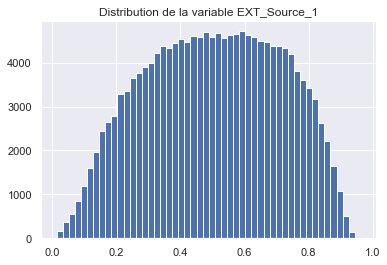

In [27]:
# Visualisation de la distribution de la variable

data.hist("EXT_SOURCE_1", bins=50)

plt.title("Distribution de la variable EXT_Source_1")
plt.show()

In [28]:
# Confirmation statistique du lien entre défaut du client et ce score

print("La F-value et la p-value via ANOVA test sont {} et {}".format(
    np.round(f_classif(df[1][df[1].EXT_SOURCE_1.isna()==False].EXT_SOURCE_1.values.reshape(-1, 1), 
                       df[1][df[1].EXT_SOURCE_1.isna()==False].TARGET)[0],2),
    f_classif(df[1][df[1].EXT_SOURCE_1.isna()==False].EXT_SOURCE_1.values.reshape(-1, 1), 
              df[1][df[1].EXT_SOURCE_1.isna()==False].TARGET)[1]))

La F-value et la p-value via ANOVA test sont [3315.68] et [0.]


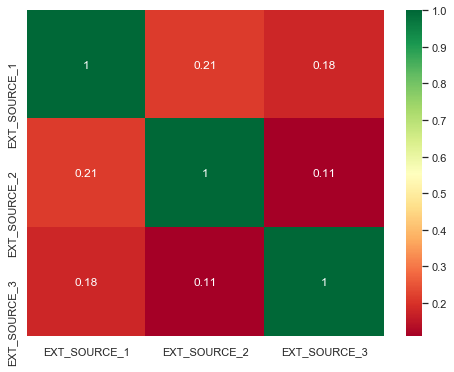

In [29]:
# Il existe plusieurs scores de sources externes via les variables 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'
# Je vais voir s'il n'existe pas une corrélation entre ces variables, afin de remplacer les NaN par ces autres
# scores

corrmat = data[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,6))

#heat map
g=sns.heatmap(data[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]][top_corr_features].corr(),
              annot=True,
              cmap="RdYlGn")

L'analyse montre qu'il n'y a pas de corrélation forte entre ces scores. Je vais donc remplacer les valeurs nulles par la moyenne.

In [30]:
data.EXT_SOURCE_1 = data.EXT_SOURCE_1.fillna(data.EXT_SOURCE_1.mean())

Passons enfin à la variable 'OCCUPATION_TYPE'

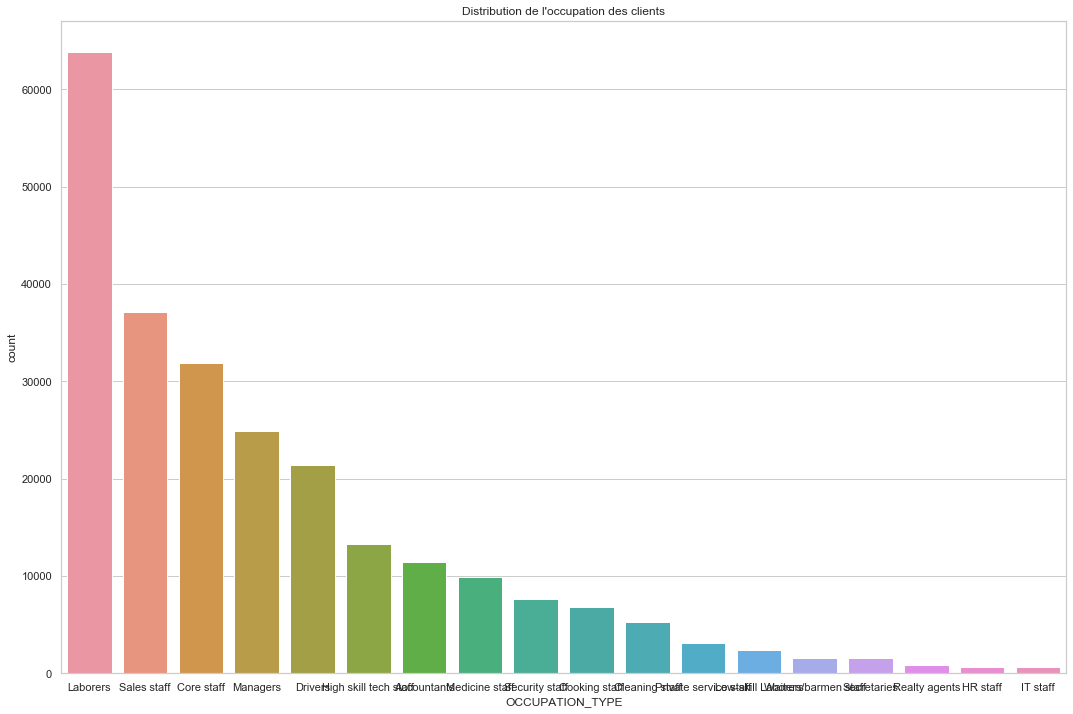

In [31]:
# Visualisation de la distribution de la variable

sns.set(style="whitegrid")
plt.figure(figsize=(18,12))

ax = sns.countplot(x="OCCUPATION_TYPE", 
                   data=data,
                  order = data.OCCUPATION_TYPE.value_counts().index)
ax.set_title("Distribution de l'occupation des clients")
#plt.savefig("occupation.png", dpi = 200)
plt.show()

In [32]:
print("Il y a {}% de valeurs manquantes pour cette variable".format(round(data.OCCUPATION_TYPE.isna().sum()/len(data),1)*100))

Il y a 30.0% de valeurs manquantes pour cette variable


Le % de valeurs nulles étant autour de 30%, je vais remplacer les NaN par le mode de cette variable

In [33]:
data.OCCUPATION_TYPE = data.OCCUPATION_TYPE.fillna(data.OCCUPATION_TYPE.mode()[0])

Je passe maintenant aux dernières variables ayant des valeurs manquantes

In [34]:
print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(data.isna().any()[lambda x: x]))

Nombre de colonnes ayant au moins 1 valeur manquante: 17


In [35]:
# Visualisation des types de variables concernées

data[data.isna().any()[lambda x: x].index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 307510
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_ANNUITY                 356219 non-null  float64
 1   AMT_GOODS_PRICE             355977 non-null  float64
 2   NAME_TYPE_SUITE             354052 non-null  object 
 3   CNT_FAM_MEMBERS             356253 non-null  float64
 4   EXT_SOURCE_2                355587 non-null  float64
 5   EXT_SOURCE_3                286622 non-null  float64
 6   OBS_30_CNT_SOCIAL_CIRCLE    355205 non-null  float64
 7   DEF_30_CNT_SOCIAL_CIRCLE    355205 non-null  float64
 8   OBS_60_CNT_SOCIAL_CIRCLE    355205 non-null  float64
 9   DEF_60_CNT_SOCIAL_CIRCLE    355205 non-null  float64
 10  DAYS_LAST_PHONE_CHANGE      356254 non-null  float64
 11  AMT_REQ_CREDIT_BUREAU_HOUR  308687 non-null  float64
 12  AMT_REQ_CREDIT_BUREAU_DAY   308687 non-null  float64
 13  AMT_REQ_CREDIT

In [36]:
# Pour la variable qualitative, je vais remplacer les valeurs manquantes par le mode

data.NAME_TYPE_SUITE = data.NAME_TYPE_SUITE.fillna(data.NAME_TYPE_SUITE.mode()[0])

Pour chacune des variables quantitatives, je vais d'abord observer la définition puis la distribution et en fonction de cette observation, supprimer éventuellement les outliers et remplacer les valeurs manquantes par la moyenne ou autre.  
  
Pour cela, je vais commencer par créer 2 fonctions.

In [37]:
def var_quant_desc(df_input, var, file):
    
    # Définition de la variable
    print("Définition de la variable: ", df[5][(df[5].Row == var) & 
                                           (df[5].Table == file)].Description.values[0])
    
    # Affichage de la distribution
    df_input.hist(var, bins=50)
    plt.title("Distribution de la variable")
    plt.show()

In [38]:
def var_quant_outlier(out, df_input, var, m):
    
    # Suppression des outliers et remplacement des valeurs manquantes par la méthode choisie
    if out == "Y":
        q1, q3 = np.nanpercentile(df_input[var], [25,75])
        iqr = q3 - q1
        limit = q3 + 1.5 * iqr
        df_input[var] = np.where(df_input[var] > limit, limit, df_input[var])
    
    if m == "mean":
        df_input[var] = df_input[var].fillna(df_input[var].mean())
    if m == "median":
        df_input[var] = df_input[var].fillna(df_input[var].median())
    else:
        df_input[var] = df_input[var].fillna(df_input[var].mode()[0])

Je vais maintenant traiter les variables avec ces 2 fonctions

Définition de la variable:  Loan annuity


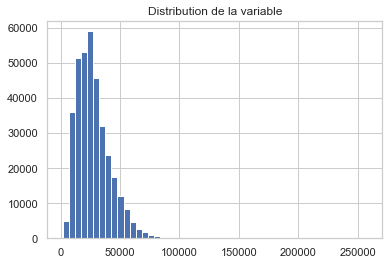

In [39]:
var_quant_desc(data, "AMT_ANNUITY", "application_{train|test}.csv")

In [40]:
# Je décide ici de remplacer la valeur manquante par 30% de la valeur du revenu (endettement de 30%)

var_quant_outlier("N", data, "AMT_ANNUITY", "mean")
data["AMT_ANNUITY"] = data["AMT_ANNUITY"].fillna(data['AMT_INCOME_TOTAL']*0.3)

Définition de la variable:  For consumer loans it is the price of the goods for which the loan is given


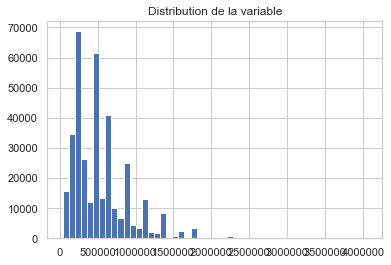

In [41]:
var_quant_desc(data,"AMT_GOODS_PRICE", "application_{train|test}.csv")

In [42]:
# Je décide ici de remplacer la valeur manquante par la valeur du prêt accordé

data["AMT_GOODS_PRICE"] = data["AMT_GOODS_PRICE"].fillna(data['AMT_CREDIT'])

Définition de la variable:  How many family members does client have


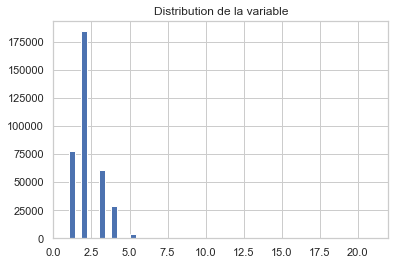

In [43]:
var_quant_desc(data,"CNT_FAM_MEMBERS", "application_{train|test}.csv")

In [44]:
data["CNT_FAM_MEMBERS"] = data["CNT_FAM_MEMBERS"].fillna(round(data["CNT_FAM_MEMBERS"].mean(),0))

Définition de la variable:  Normalized score from external data source


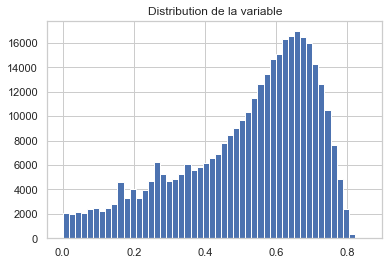

Définition de la variable:  Normalized score from external data source


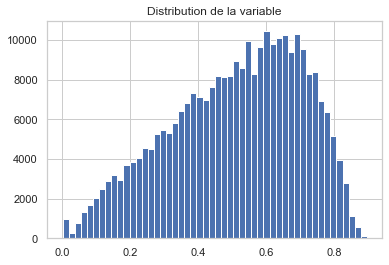

In [45]:
cols1 = ["EXT_SOURCE_2", "EXT_SOURCE_3"]

for c in cols1:
    var_quant_desc(data,c, "application_{train|test}.csv")

In [46]:
for c in cols1:
    var_quant_outlier("N", data,c, "mean")

Définition de la variable:  How many observation of client's social surroundings with observable 30 DPD (days past due) default


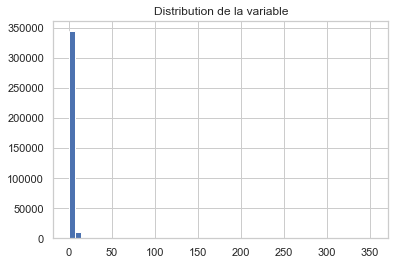

Définition de la variable:  How many observation of client's social surroundings defaulted on 30 DPD (days past due) 


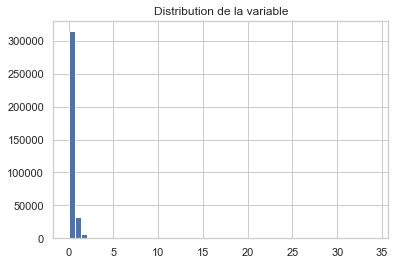

Définition de la variable:  How many observation of client's social surroundings with observable 60 DPD (days past due) default


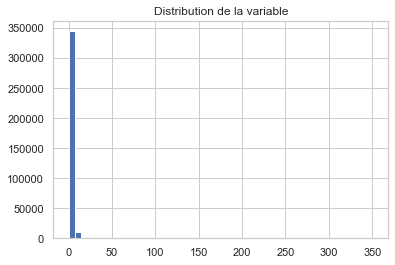

Définition de la variable:  How many observation of client's social surroundings defaulted on 60 (days past due) DPD


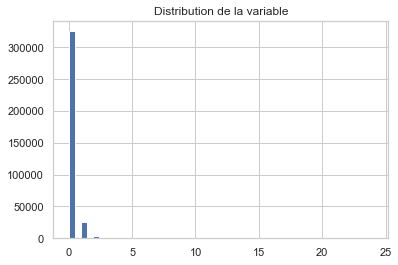

In [47]:
cols2 = ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", 
         "DEF_60_CNT_SOCIAL_CIRCLE"]

for c in cols2:
    var_quant_desc(data,c, "application_{train|test}.csv")

In [48]:
for c in cols2:
    var_quant_outlier("Y", data,c, "mean")

Définition de la variable:  How many days before application did client change phone


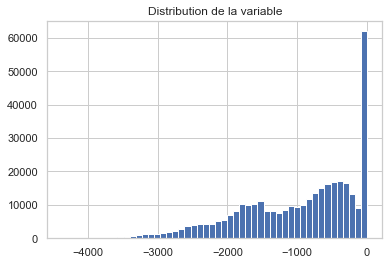

In [49]:
var_quant_desc(data,"DAYS_LAST_PHONE_CHANGE", "application_{train|test}.csv")

In [50]:
data["DAYS_LAST_PHONE_CHANGE"] = data["DAYS_LAST_PHONE_CHANGE"].abs()
var_quant_outlier("N", data,"DAYS_LAST_PHONE_CHANGE", "mean")

Définition de la variable:  Number of enquiries to Credit Bureau about the client one hour before application


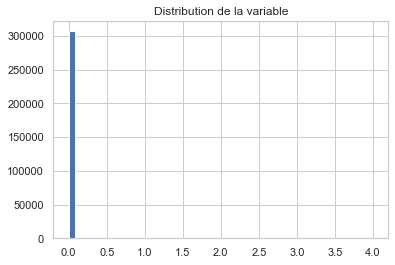

Définition de la variable:  Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application)


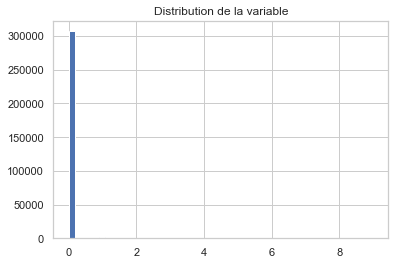

Définition de la variable:  Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application)


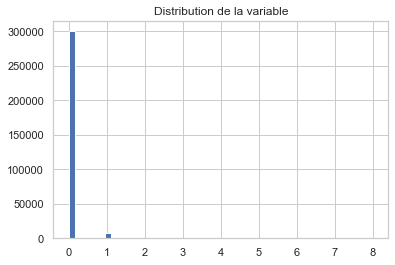

Définition de la variable:  Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application)


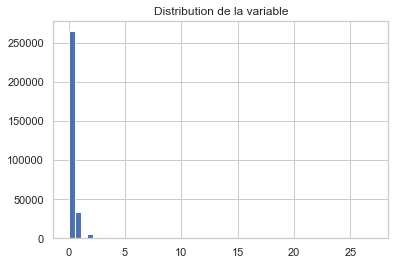

Définition de la variable:  Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)


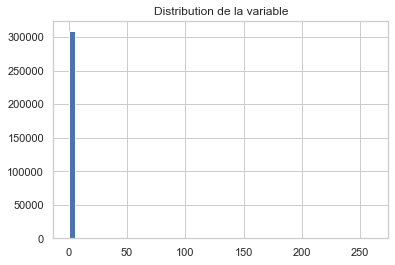

Définition de la variable:  Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)


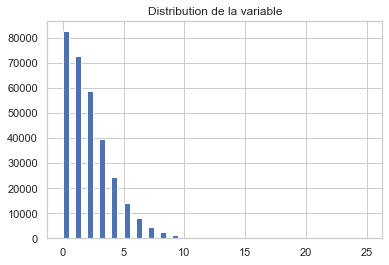

In [51]:
cols3 = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
         "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]

for c in cols3:
    var_quant_desc(data,c, "application_{train|test}.csv")

In [52]:
for c in cols3:
    var_quant_outlier("N", data,c, "mean")

Il n'y a désormais plus de valeurs manquantes dans ce jeu de données.

In [53]:
print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(data.isna().any()[lambda x: x]))

Nombre de colonnes ayant au moins 1 valeur manquante: 0


<a id="section1.3"> </a>
## 1.C Traitement des outliers sur les variables qualitatives restantes

In [54]:
cols_to_do = list(set(data.columns)-set(nan_cols))

In [55]:
cols_to_do.remove('Living_info_prct')
cols_to_do.remove('train_test')
len(cols_to_do)

54

Cas des variables FLAG_DOCUMENT

In [56]:
list_flags = ['FLAG_DOCUMENT_10','FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
              'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 
              'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 
              'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9']

In [57]:
# Affichage des définitions
list_defs = []
for c in list_flags:
    list_defs.append(df[5][(df[5].Row == c) & (df[5].Table == "application_{train|test}.csv")].Description.values[0])

np.unique(list_defs)

array(['Did client provide document 10', 'Did client provide document 11',
       'Did client provide document 12', 'Did client provide document 13',
       'Did client provide document 14', 'Did client provide document 15',
       'Did client provide document 16', 'Did client provide document 17',
       'Did client provide document 18', 'Did client provide document 19',
       'Did client provide document 2', 'Did client provide document 20',
       'Did client provide document 21', 'Did client provide document 3',
       'Did client provide document 4', 'Did client provide document 5',
       'Did client provide document 6', 'Did client provide document 7',
       'Did client provide document 8', 'Did client provide document 9'],
      dtype='<U30')

On remarque que ces variables ne prennent que la valeur 1 ou 0 en fonction de la réponse à la question.  
Il n'est pas nécessaire de traiter les outliers.  
Vérifions s'il en est de même pour les autres variables de type flag 

In [58]:
list_flags2 = ['FLAG_CONT_MOBILE','FLAG_EMAIL','FLAG_EMP_PHONE','FLAG_MOBIL', 'FLAG_OWN_CAR', 
               'FLAG_OWN_REALTY', 'FLAG_PHONE', 'FLAG_WORK_PHONE']

On remarque que 2 de ces variables sont quantitatives et devront être encodées plus tard. Pas de traitement sur celles-ci en termes d'outliers

In [59]:
df[1][list_flags2].dtypes

FLAG_CONT_MOBILE     int64
FLAG_EMAIL           int64
FLAG_EMP_PHONE       int64
FLAG_MOBIL           int64
FLAG_OWN_CAR        object
FLAG_OWN_REALTY     object
FLAG_PHONE           int64
FLAG_WORK_PHONE      int64
dtype: object

Définition de la variable:  Was mobile phone reachable (1=YES, 0=NO)


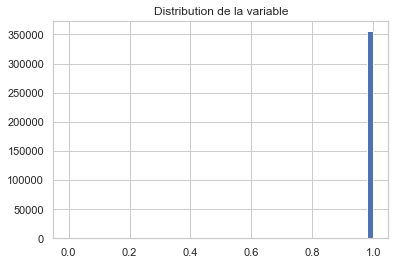

Définition de la variable:  Did client provide email (1=YES, 0=NO)


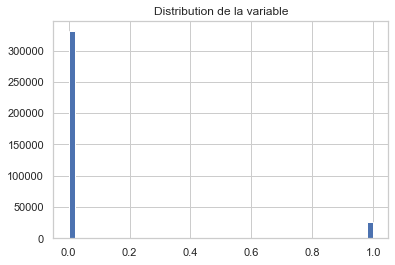

Définition de la variable:  Did client provide work phone (1=YES, 0=NO)


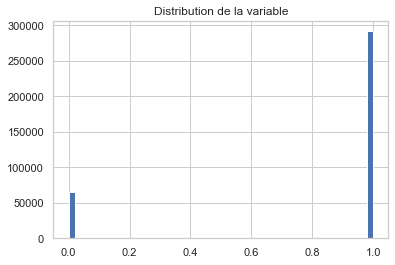

Définition de la variable:  Did client provide mobile phone (1=YES, 0=NO)


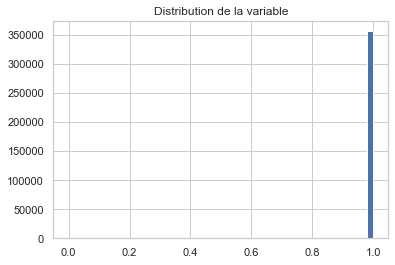

Définition de la variable:  Did client provide home phone (1=YES, 0=NO)


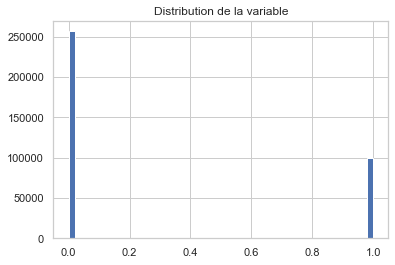

Définition de la variable:  Did client provide home phone (1=YES, 0=NO)


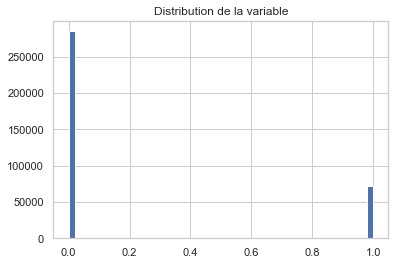

In [60]:
del list_flags2[4:6]
for c in list_flags2:
    var_quant_desc(data,c, "application_{train|test}.csv")

Parmi les colonnes restant à explorer, je ne vais pas considérer les variables catégorielles

In [61]:
list_rest = ['AMT_CREDIT','AMT_INCOME_TOTAL','CNT_CHILDREN', 'CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION','HOUR_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY','LIVE_REGION_NOT_WORK_REGION', 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE','ORGANIZATION_TYPE', 'REGION_POPULATION_RELATIVE',
 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION','WEEKDAY_APPR_PROCESS_START']
df[1][list_rest].dtypes

AMT_CREDIT                     float64
AMT_INCOME_TOTAL               float64
CNT_CHILDREN                     int64
CODE_GENDER                     object
DAYS_BIRTH                       int64
DAYS_EMPLOYED                    int64
DAYS_ID_PUBLISH                  int64
DAYS_REGISTRATION              float64
HOUR_APPR_PROCESS_START          int64
LIVE_CITY_NOT_WORK_CITY          int64
LIVE_REGION_NOT_WORK_REGION      int64
NAME_CONTRACT_TYPE              object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
NAME_INCOME_TYPE                object
ORGANIZATION_TYPE               object
REGION_POPULATION_RELATIVE     float64
REGION_RATING_CLIENT             int64
REGION_RATING_CLIENT_W_CITY      int64
REG_CITY_NOT_LIVE_CITY           int64
REG_CITY_NOT_WORK_CITY           int64
REG_REGION_NOT_LIVE_REGION       int64
REG_REGION_NOT_WORK_REGION       int64
WEEKDAY_APPR_PROCESS_START      object
dtype: object

In [62]:
last_col = ['AMT_CREDIT','AMT_INCOME_TOTAL','CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
            'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION','HOUR_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY',
            'LIVE_REGION_NOT_WORK_REGION', 'REGION_POPULATION_RELATIVE','REGION_RATING_CLIENT', 
            'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
            'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION']

Définition de la variable:  Credit amount of the loan


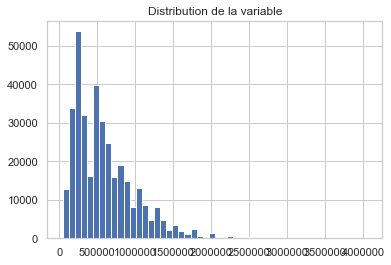

Définition de la variable:  Income of the client


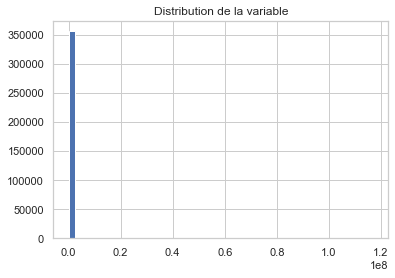

Définition de la variable:  Number of children the client has


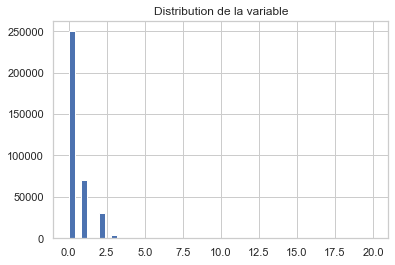

Définition de la variable:  Client's age in days at the time of application


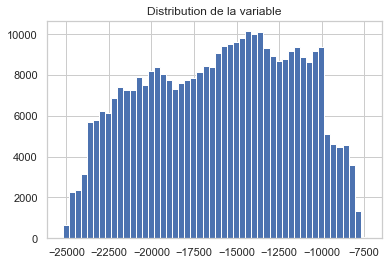

Définition de la variable:  How many days before the application the person started current employment


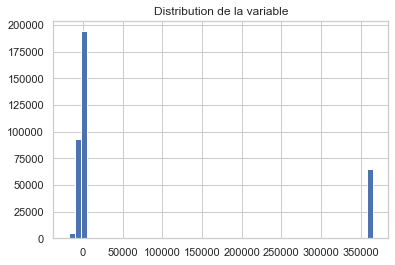

Définition de la variable:  How many days before the application did client change the identity document with which he applied for the loan


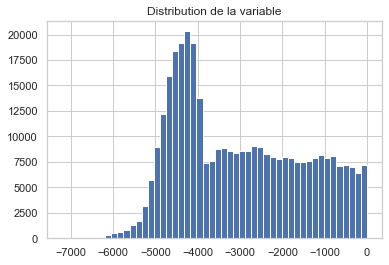

Définition de la variable:  How many days before the application did client change his registration


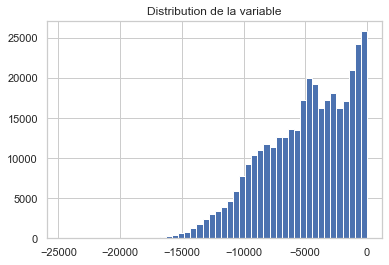

Définition de la variable:  Approximately at what hour did the client apply for the loan


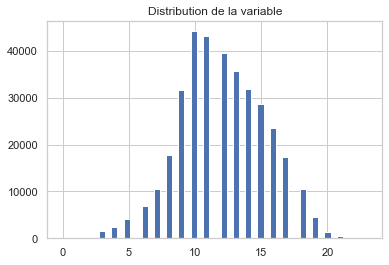

Définition de la variable:  Flag if client's contact address does not match work address (1=different, 0=same, at city level)


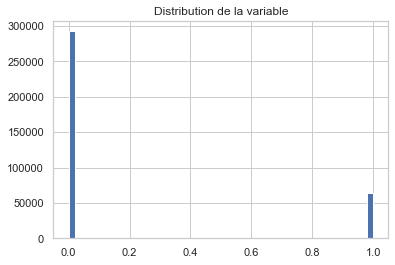

Définition de la variable:  Flag if client's contact address does not match work address (1=different, 0=same, at region level)


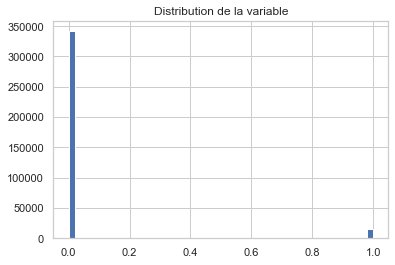

Définition de la variable:  Normalized population of region where client lives (higher number means the client lives in more populated region)


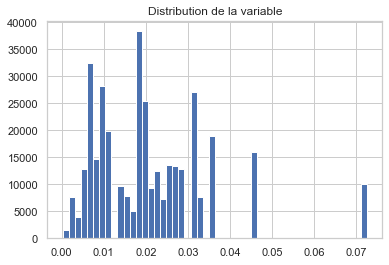

Définition de la variable:  Our rating of the region where client lives (1,2,3)


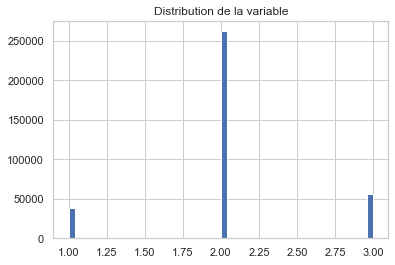

Définition de la variable:  Our rating of the region where client lives with taking city into account (1,2,3)


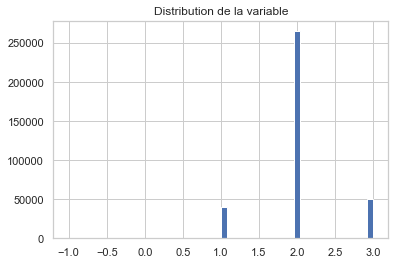

Définition de la variable:  Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)


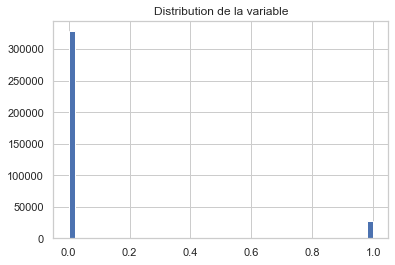

Définition de la variable:  Flag if client's permanent address does not match work address (1=different, 0=same, at city level)


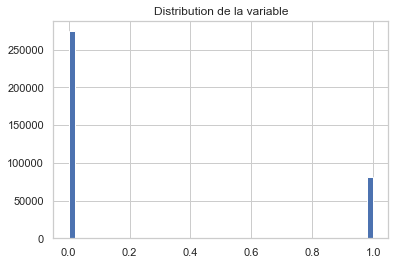

Définition de la variable:  Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)


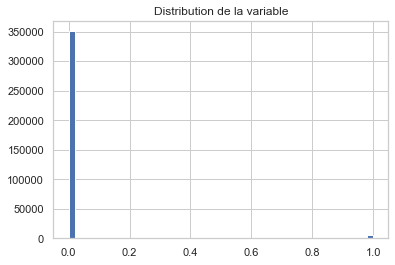

Définition de la variable:  Flag if client's permanent address does not match work address (1=different, 0=same, at region level)


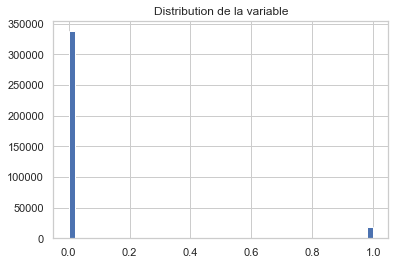

In [63]:
# Définition et distributions de ces variables

for c in last_col:
    var_quant_desc(data,c, "application_{train|test}.csv")

Pour la variable 'DAYS_EMPLOYED' on remarque des valeurs extrêmes qui pourraient indiquer des personnes sans emploi. Cela se confirme quand on observe qu'une seule valeur est prise quand la variable est positive, et que cette valeur est égale à 1000 ans (en jours) 

Définition de la variable:  How many days before the application the person started current employment


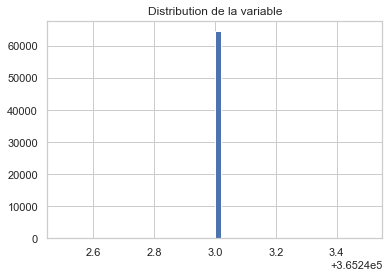

In [64]:
var_quant_desc(data[data['DAYS_EMPLOYED']>0],'DAYS_EMPLOYED', "application_{train|test}.csv")

Quand on observe l'occupation de ces personnes, ce sont soit des retraités, soit des personnes sans emploi.  
Une vérification sur les personnes sans emploi confirment que la seule valeur correspondant à la variable est 1000 ans

In [65]:
print("Types de professions pour lesquelles le nombre de jours est positif: {}".format(
    data[data['DAYS_EMPLOYED']>0]['NAME_INCOME_TYPE'].unique()))

Types de professions pour lesquelles le nombre de jours est positif: ['Pensioner' 'Unemployed']


In [66]:
print("Valeur de la variable DAYS_EMPLOYED pour les clients sans emploi: {}".format(
    data[data['NAME_INCOME_TYPE'] == 'Unemployed']['DAYS_EMPLOYED'].unique()))

Valeur de la variable DAYS_EMPLOYED pour les clients sans emploi: [365243]


Afin de ne pas déséquilibrer le jeu de données, je ne vais pas laisser cette valeur si élevée mais la remplacer par une valeur positive qui est l'opposé de la moyenne des données négatives

In [67]:
data.DAYS_EMPLOYED.replace([365243], [-data[data['DAYS_EMPLOYED']<0]['DAYS_EMPLOYED'].mean()], inplace=True)

Définition de la variable:  How many days before the application the person started current employment


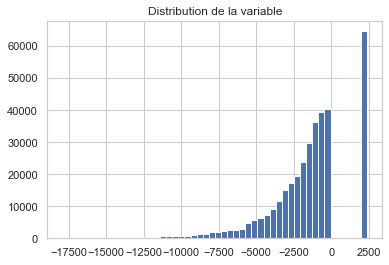

In [68]:
var_quant_desc(data,'DAYS_EMPLOYED', "application_{train|test}.csv")

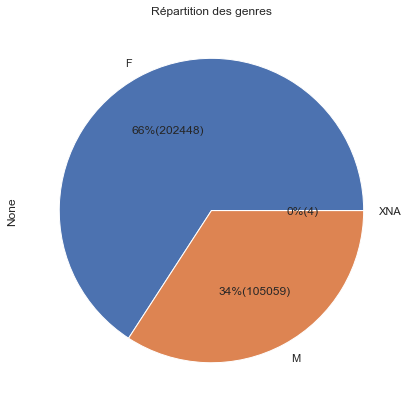

In [69]:
# Enfin la variable Genre contenant des valeurs manquantes (valeur XNA), je vais remplacer XNA par le mode de cette
# variable catégorielle

variable = df[1][["CODE_GENDER"]].groupby("CODE_GENDER").size()

sns.set()
variable.plot(kind='pie', 
              title='Répartition des genres', 
              figsize=[7,7],
              autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*variable.sum()))
plt.show()


data.CODE_GENDER.replace(['XNA'], ['F'], inplace=True)

<a id="section1.4"> </a>
## 1.D Analyse Exploratoire

In [70]:
### Création d'un Df incluant la variable Target pour analyse exploratoire

df_explo = data[data.train_test == "train"]
df_explo = pd.concat([df_explo, y_train], axis=1, sort=False)
df_explo.shape

(307511, 78)

### Analyse variables catégorielles

#### Fonction représentation graphique

Fonction qui représente la distribution d'une variable du jeu de données, ainsi que le % de cette variable représentée par les prêts non remboursés (TARGET = 1)


In [71]:
def plot_stats(feature, df, label_rotation=False,horizontal_layout=True):
    
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Nombre de prêts': temp.values})

    # % représentée par prêts non remboursés pour chaque valeur de la catégorie
    cat_perc = df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Nombre de prêts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('% représenté par des problèmes de remboursement', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

#### Analyses

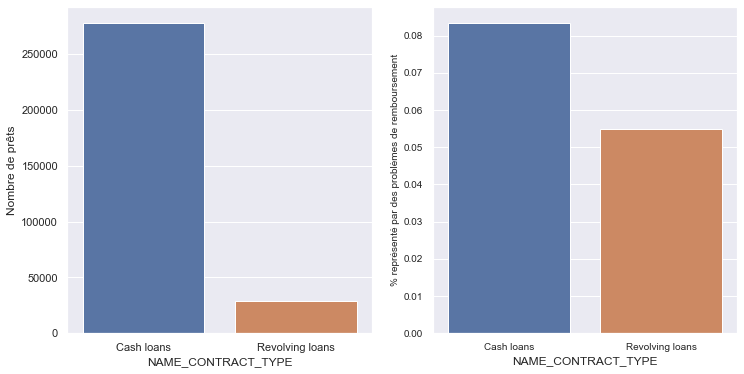

In [72]:
# Analyse des prêts par type

plot_stats('NAME_CONTRACT_TYPE', df_explo)

Contract type Revolving loans are just a small fraction (10%) from the total number of loans; in the same time, a larger amount of Revolving loans, comparing with their frequency, are not repaid.

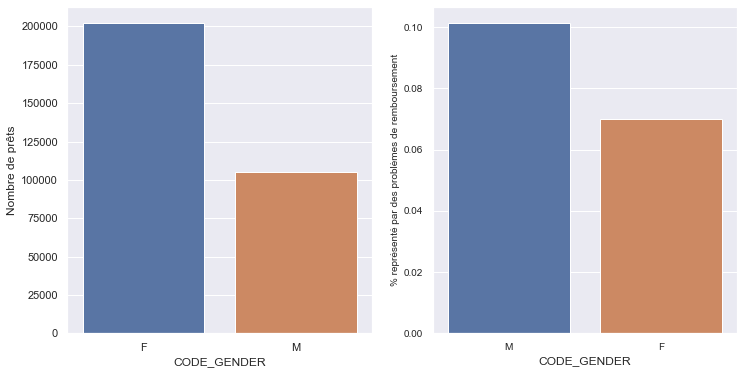

In [73]:
# Analyse des prêts par genre

plot_stats('CODE_GENDER', df_explo)

The number of female clients is almost double the number of male clients. Looking to the percent of defaulted credits, males have a higher chance of not returning their loans (around 10%), comparing with women (around 7%).

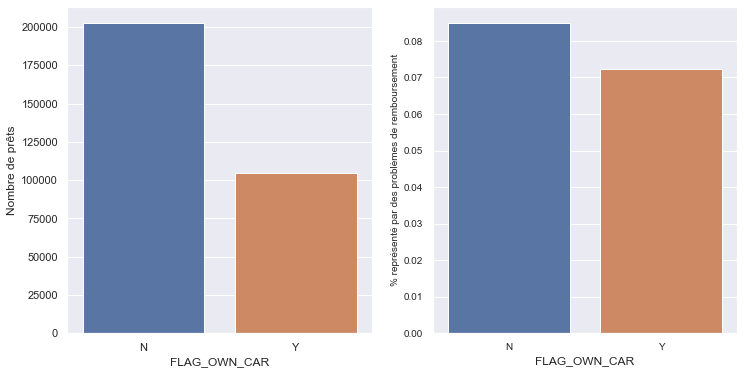

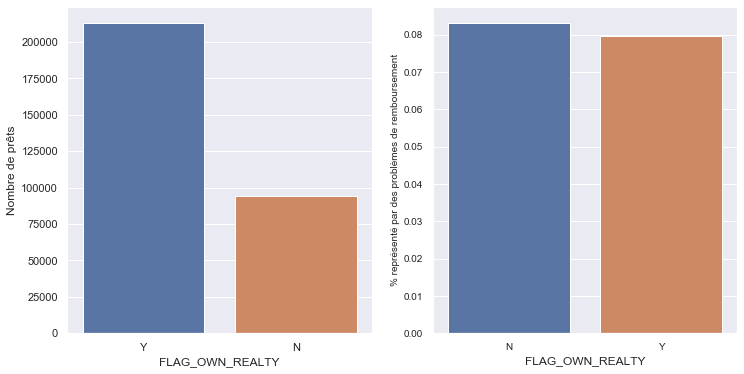

In [74]:
# Distribution en fonction de la possession d'une voiture ou d'un bien immobilier

plot_stats('FLAG_OWN_CAR', df_explo)
plot_stats('FLAG_OWN_REALTY', df_explo)

The clients that own a car are almost a half of the ones that don't own one. The clients that own a car are less likely to not repay a car that the ones that own. Both categories have not-repayment rates around 8%.

The clients that own real estate are more than double of the ones that don't own. Both categories (owning real estate or not owning) have not-repayment rates around 8%.

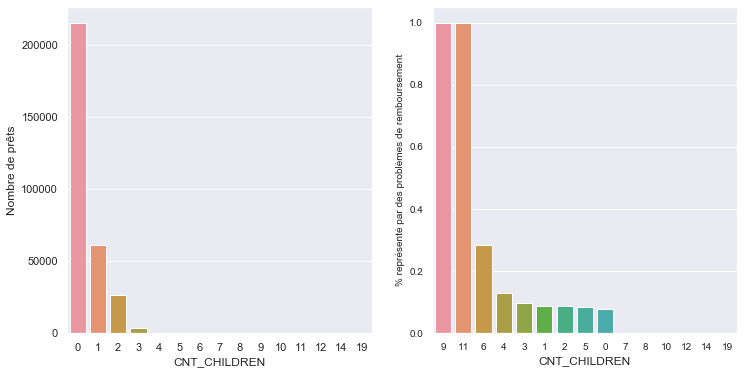

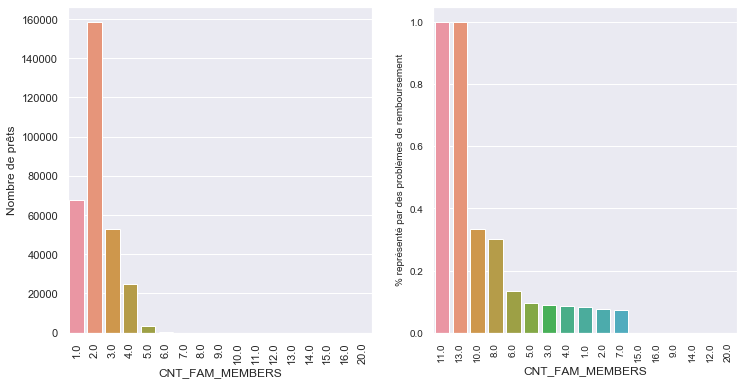

In [75]:
# Distribution en fonction du nombre d'enfants et de membres de la famille

plot_stats('CNT_CHILDREN', df_explo)
plot_stats('CNT_FAM_MEMBERS', df_explo, True, True)

Most of the clients taking a loan have no children. The number of loans associated with the clients with one children are 4 times smaller, the number of loans associated with the clients with two children are 8 times smaller; clients with 3, 4 or more children are much more rare.

As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children).

As for clients with 9 or 11 children, the percent of loans not repaid is 100%.

Clients with family members of 2 are most numerous, followed by 1 (single persons), 3 (families with one child) and 4.

Clients with family size of 11 and 13 have 100% not repayment rate. Other families with 10 or 8 members have percents of not repayment of loans over 30%. Families with 6 or less members have repayment rates close to the 10% average.

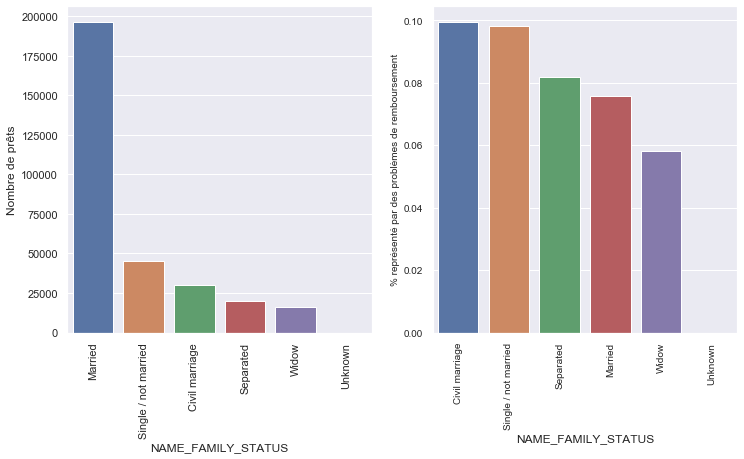

In [76]:
# Distribution en fonction du statut familial

plot_stats('NAME_FAMILY_STATUS', df_explo, True, True)

Most of clients are married, followed by Single/not married and civil marriage.

In terms of percentage of not repayment of loan, Civil marriage has the highest percent of not repayment (10%), with Widow the lowest (exception being Unknown).

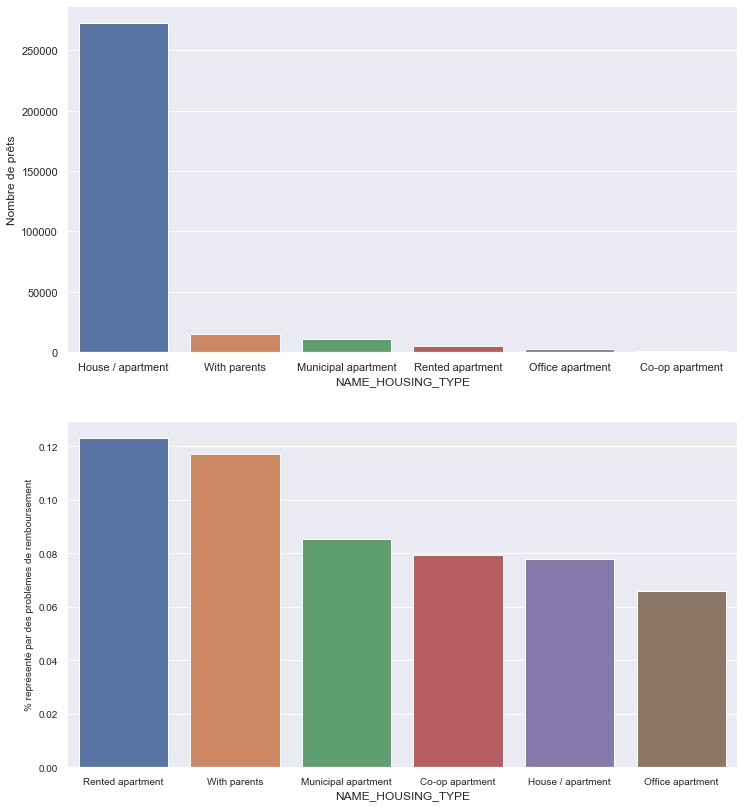

In [77]:
# Distribution en fonction du type de logement

plot_stats('NAME_HOUSING_TYPE', df_explo, False, False)

Over 250,000 applicants for credits registered their housing as House/apartment. Following categories have a very small number of clients (With parents, Municipal appartment).

From these categories, Rented apartment and With parents have higher than 10% not-repayment rate.

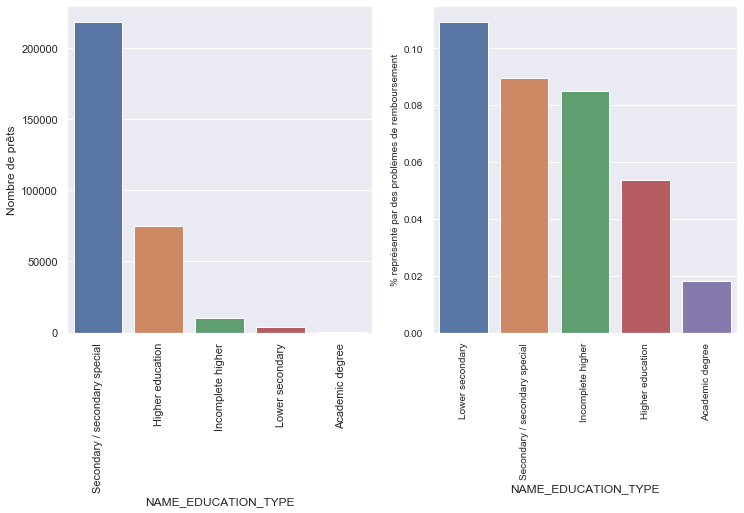

In [78]:
# Distribution en fonction du type d'éducation

plot_stats('NAME_EDUCATION_TYPE', df_explo, True)

Majority of the clients have Secondary / secondary special education, followed by clients with Higher education. Only a very small number having an academic degree.

The Lower secondary category, although rare, have the largest rate of not returning the loan (11%). The people with Academic degree have less than 2% not-repayment rate.

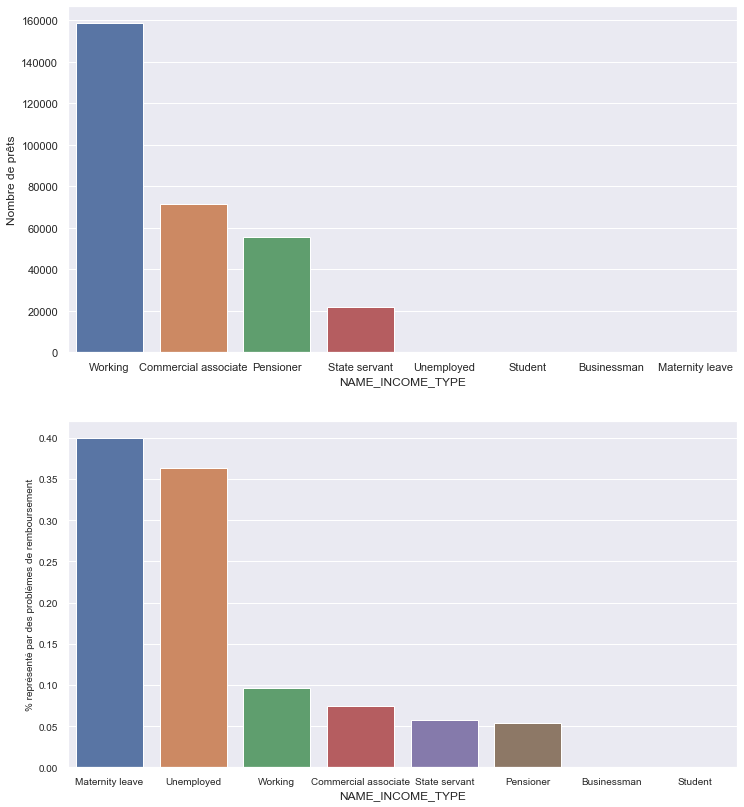

In [79]:
# Distribution en fonction du type de source de revenus du client

plot_stats('NAME_INCOME_TYPE', df_explo, False, False)

Most of applicants for loans are income from Working, followed by Commercial associate, Pensioner and State servant.

The applicants with the type of income Maternity leave have almost 40% ratio of not returning loans, followed by Unemployed (36%). The rest of types of incomes are under the average of 10% for not returning loans.

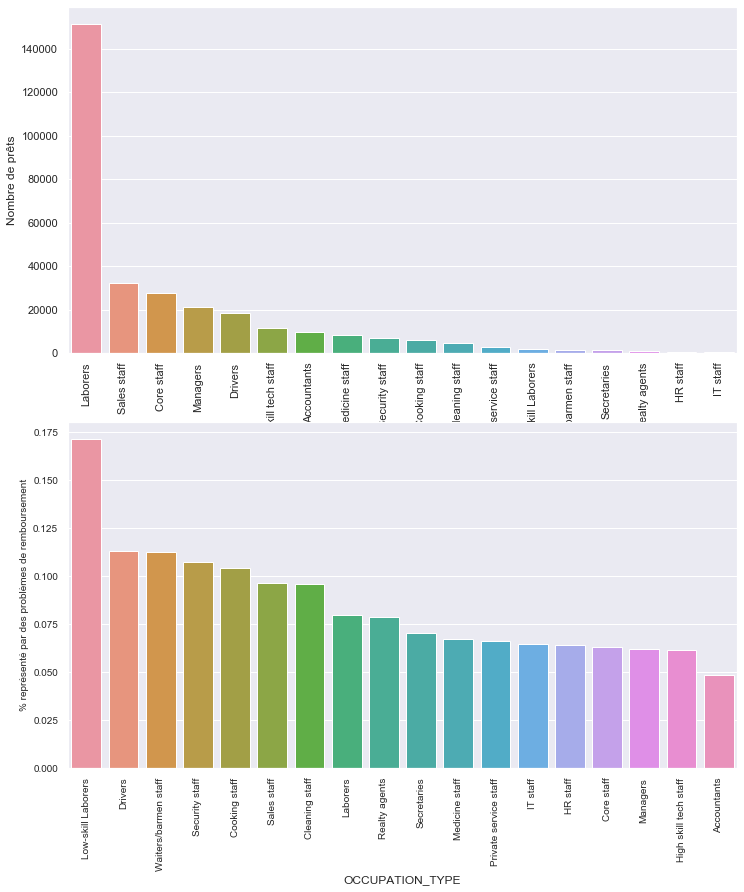

In [80]:
# Distribution en fonction du type d'activité pro du client

plot_stats('OCCUPATION_TYPE', df_explo, True, False)

Most of the loans are taken by Laborers, followed by Sales staff. IT staff take the lowest amount of loans.

The category with highest percent of not repaid loans are Low-skill Laborers (above 17%), followed by Drivers and Waiters/barmen staff, Security staff and Cooking staff.

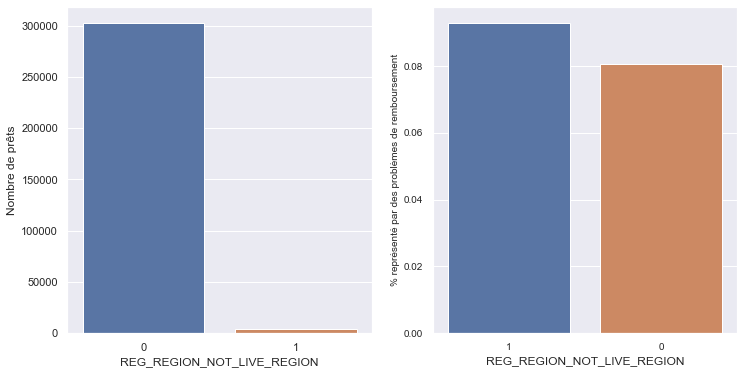

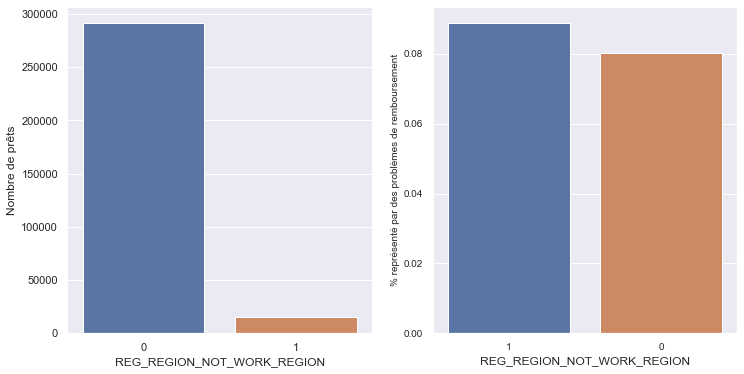

In [81]:
# Distribution en fonction de la région de résidence par rapport à la résidence du lieu de travail

plot_stats('REG_REGION_NOT_LIVE_REGION', df_explo)
plot_stats('REG_REGION_NOT_WORK_REGION', df_explo)

Very few people are registered in not live or not work region. Generally, the rate of not return is slightly larger for these cases than in the rest (slightly above 8% compared with approx. 8%)

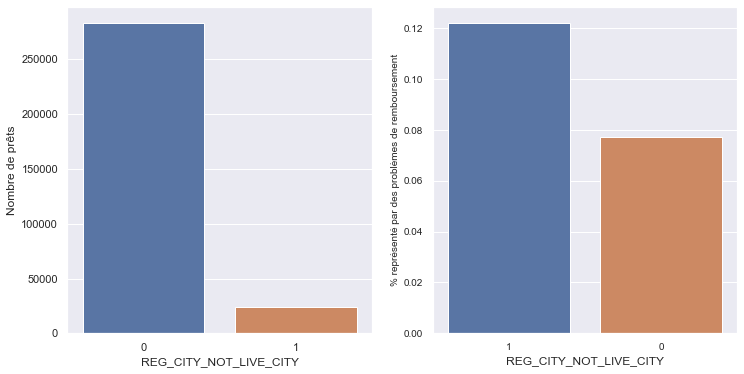

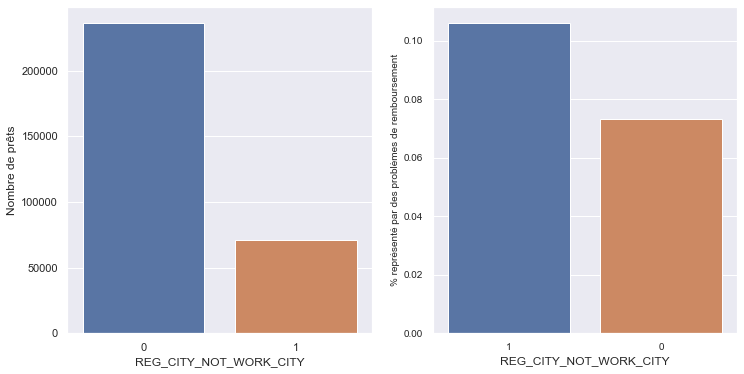

In [82]:
# Distribution en fonction de la ville de résidence par rapport à la ville du lieu de travail

plot_stats('REG_CITY_NOT_LIVE_CITY', df_explo)
plot_stats('REG_CITY_NOT_WORK_CITY', df_explo)

Generally, much more people register in the city they live or work (a larger number register differently in the working city than living city).

The ones that register in different city than the working or living city are more frequently not-repaying the loans than the ones that register same city (work 11% or live 12%).

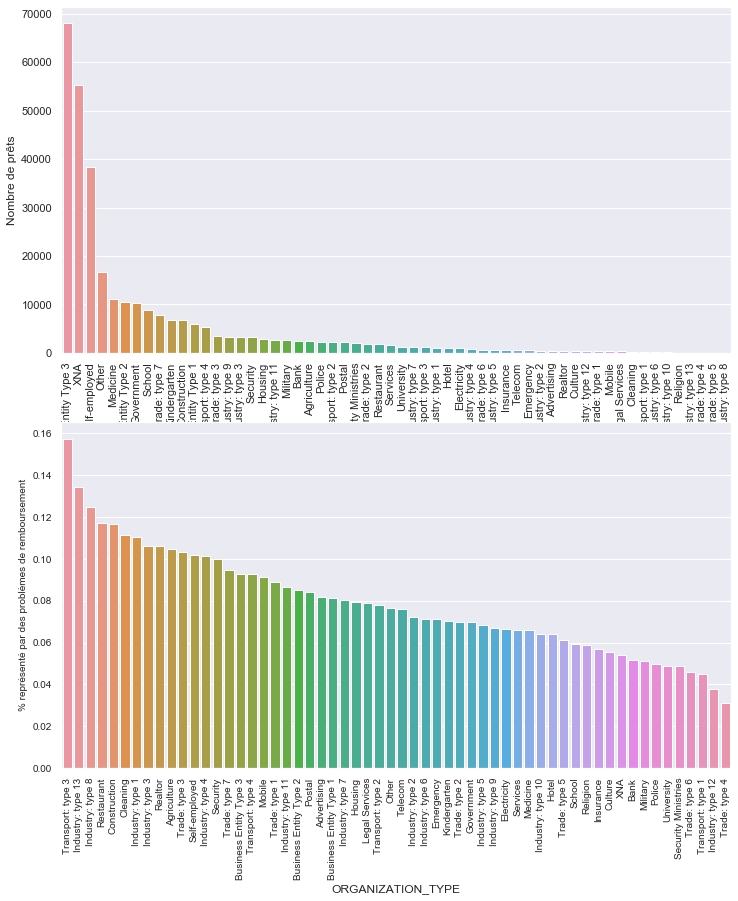

In [83]:
# Distribution en fonction de la ville de résidence par rapport à la ville du lieu de travail

plot_stats('ORGANIZATION_TYPE', df_explo, True, False)

In [84]:
# Je remplace les valeurs manquantes XNA par "Other"

data.ORGANIZATION_TYPE.replace(['XNA'], ['Other'], inplace=True)

### Analyse variables quantitatives

#### Fonctions représentation graphique

Une fonction est créée pour superposer pour certaines variables les distributions correspondant à chaque catégorie de prêt (TARGET = 0 ou 1)

In [85]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(df, var, nrow=2):
    
    i = 0
    t1 = df.loc[df['TARGET'] != 0]
    t0 = df.loc[df['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.distplot(t1[feature],label="TARGET = 1", hist = False)
        sns.distplot(t0[feature],label="TARGET = 0", hist = False)
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

#### Analyse variables quantitatives

In [86]:
# Je vais d'abord convertir les données qui sont en nombres de jours en positif et en années 
# (sauf DAYS_EMPLOYED - voir ci-dessus)

col_yr = ['DAYS_BIRTH', 'DAYS_REGISTRATION','DAYS_ID_PUBLISH']

for c in col_yr:
    df_explo[c] = - df_explo[c] / 365

<Figure size 432x288 with 0 Axes>

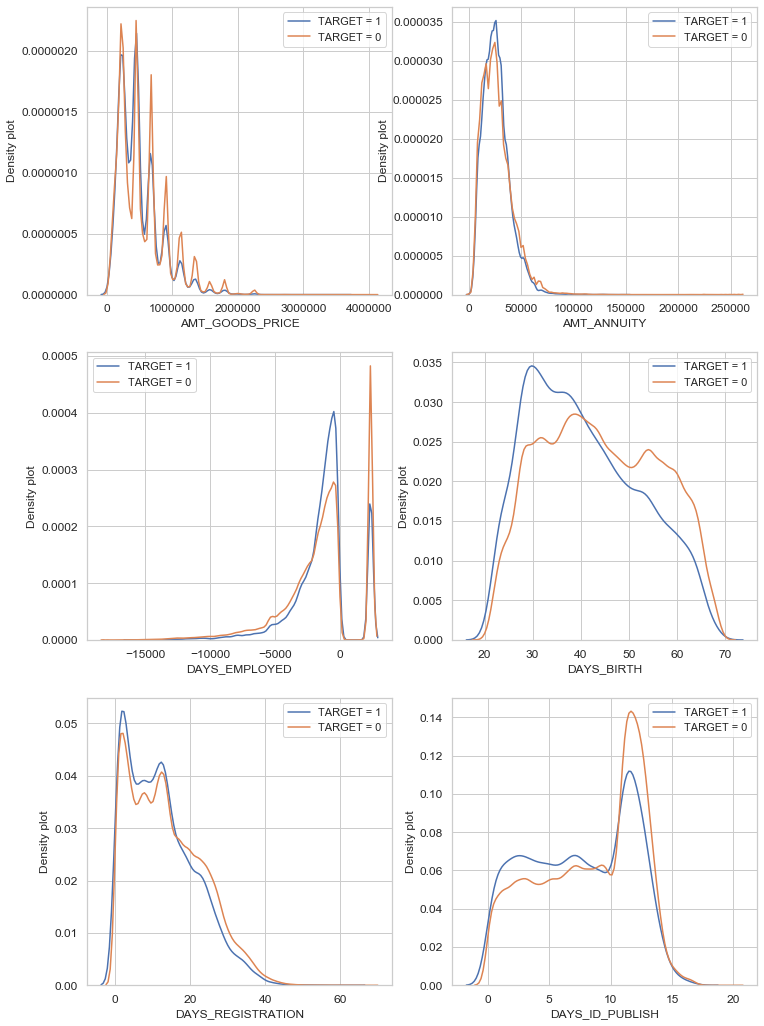

In [87]:
cols = ['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH']

plot_distribution_comp(df_explo, cols, nrow = 3)

La principale observation concerne le nombre de jours où le client a été employé. On voit clairement que pour les prêts en défaut, ce nombre de jours est relativement faible alors que nous observons un pic pour les prêts remboursés parmi les retraités (personnes relativement aisées)

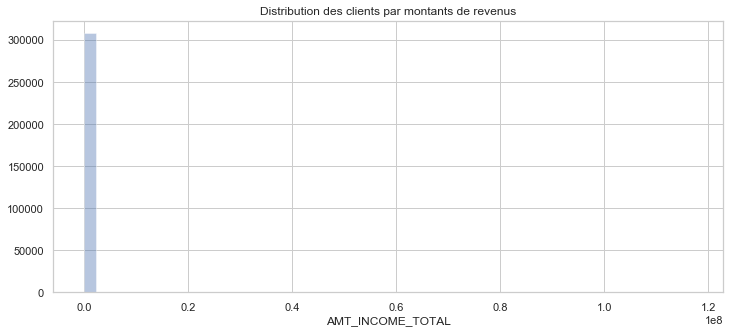

In [89]:
# Distribution des revenus des clients

plt.figure(figsize=(12,5))
plt.title("Distribution des clients par montants de revenus")
ax = sns.distplot(df_explo['AMT_INCOME_TOTAL'], kde= False)

On peut voir que la distribution est fortement influencée par les valeurs extrêmes. Nous allons utiliser un boxplot en excluant les outliers

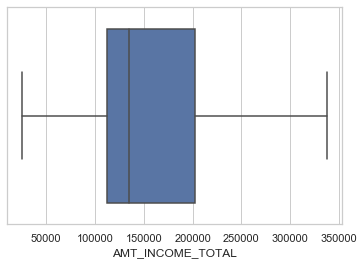

In [90]:
# Distribution pour les clients avec TARGET = 1

ax = sns.boxplot(x='AMT_INCOME_TOTAL', data=df_explo[df_explo.TARGET == 1], showfliers = False)

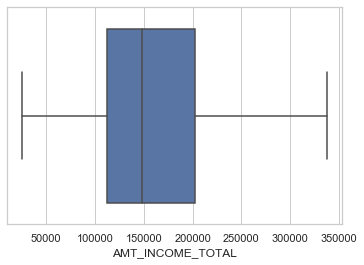

In [91]:
# Distribution pour les clients avec TARGET = 0

ax = sns.boxplot(x='AMT_INCOME_TOTAL', data=df_explo[df_explo.TARGET == 0], showfliers = False)

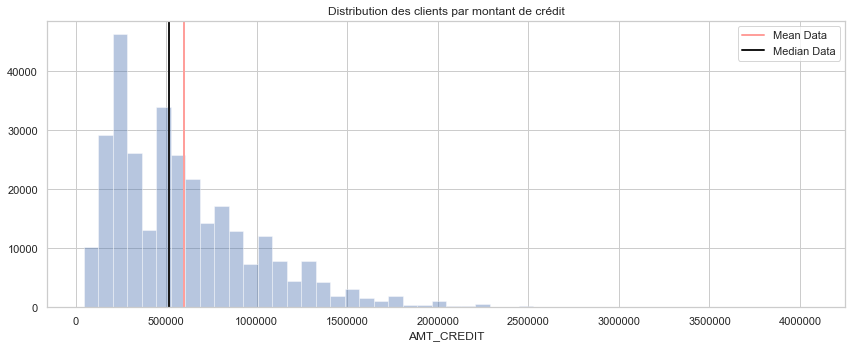

In [92]:
# Distribution des montants de crédit des clients

plt.figure(figsize=(12,5))
plt.title("Distribution des clients par montant de crédit")
ax = sns.distplot(df_explo['AMT_CREDIT'], kde= False)
custom_lines = [plt.axvline(df_explo['AMT_CREDIT'].mean(), color = 'r', linewidth = 2), 
               plt.axvline(df_explo['AMT_CREDIT'].median(), color = 'k', linewidth = 2)]

plt.legend(custom_lines, ["Mean Data","Median Data"])

plt.tight_layout()
plt.show()

<a id="section1.5"> </a>
## 1.E Feature engineering

### Création de variables

Comme les variables AMT_INCOME_TOTAL et 'AMT_CREDIT' sont très dispersées et influencées par des valeurs extrêmes, je vais créer une variable étant le ratio entre les 2 variables afin de voir la distribution de cette nouvelle variable

In [93]:
data["ratio_credit_income"] = data['AMT_CREDIT'] / data["AMT_INCOME_TOTAL"]

In [94]:
df_explo = data[data.train_test == "train"]
df_explo = pd.concat([df_explo, y_train], axis=1, sort=False)

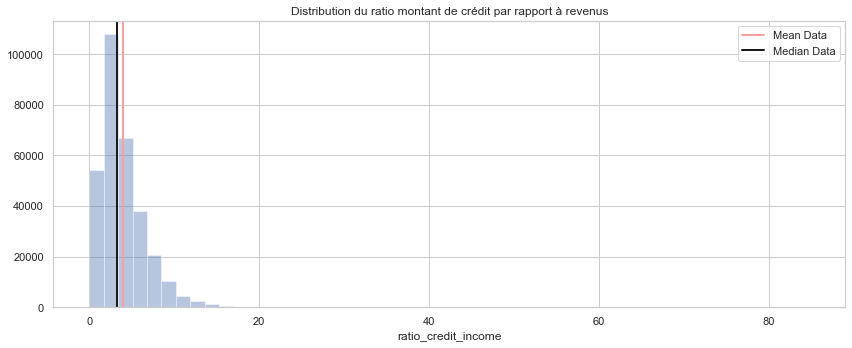

In [95]:
# Distribution du ratio montant de crédit par rapport à revenus

plt.figure(figsize=(12,5))
plt.title("Distribution du ratio montant de crédit par rapport à revenus")
ax = sns.distplot(df_explo['ratio_credit_income'], kde= False)
custom_lines = [plt.axvline(df_explo['ratio_credit_income'].mean(), color = 'r', linewidth = 2), 
               plt.axvline(df_explo['ratio_credit_income'].median(), color = 'k', linewidth = 2)]

plt.legend(custom_lines, ["Mean Data","Median Data"])

plt.tight_layout()
plt.show()

A nouveau une distribution 'left skewed'. On peut remarquer des clients contractant des prêts au moins 40 fois supérieurs à leurs revenus.  
  
De la même manière, je vais créer une variable indiquant combien l'annuité représente du revenu total

In [96]:
data["ratio_income_annuity"] = data["AMT_ANNUITY"] / data["AMT_INCOME_TOTAL"]

df_explo = data[data.train_test == "train"]
df_explo = pd.concat([df_explo, y_train], axis=1, sort=False)

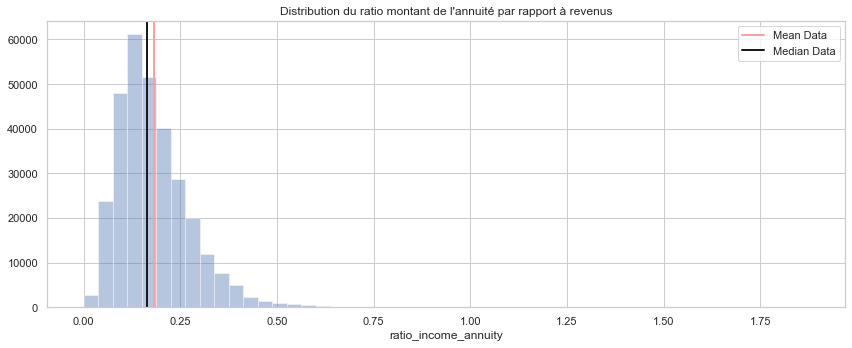

In [97]:
# Distribution du ratio montant de l'annuité par rapport à revenus

plt.figure(figsize=(12,5))
plt.title("Distribution du ratio montant de l'annuité par rapport à revenus")
ax = sns.distplot(df_explo["ratio_income_annuity"], kde= False)
custom_lines = [plt.axvline(df_explo["ratio_income_annuity"].mean(), color = 'r', linewidth = 2), 
               plt.axvline(df_explo["ratio_income_annuity"].median(), color = 'k', linewidth = 2)]

plt.legend(custom_lines, ["Mean Data","Median Data"])

plt.tight_layout()
plt.show()

Il est très surprenant de voir que certains clients ont une annuité supérieure à leur revenu. Regardons la distribution de leur TARGET

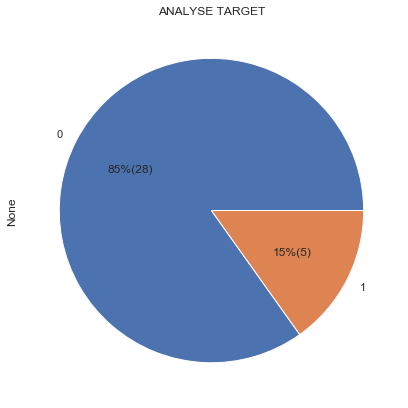

In [98]:
variable = df_explo[df_explo["ratio_income_annuity"]>1].groupby("TARGET").size()

sns.set()
variable.plot(kind='pie', 
              title='ANALYSE TARGET', 
              figsize=[7,7],
              autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*variable.sum()))
plt.show()

Seulement 15% de ces clients ont fait défaut, ce qui est certes au dessus de la moyenne mais contre-intuitif. On peut imaginer que le prêt a été remboursé via d'autres crédits, ou par la vente du bien.  

Je vais désormais créer une variable représentant la durée du crédit en années comme le rapport entre le montant total du crédit et les remboursements annuels (annuity)

In [99]:
data["TENOR"] = data['AMT_CREDIT'] / data["AMT_ANNUITY"]

df_explo = data[data.train_test == "train"]
df_explo = pd.concat([df_explo, y_train], axis=1, sort=False)

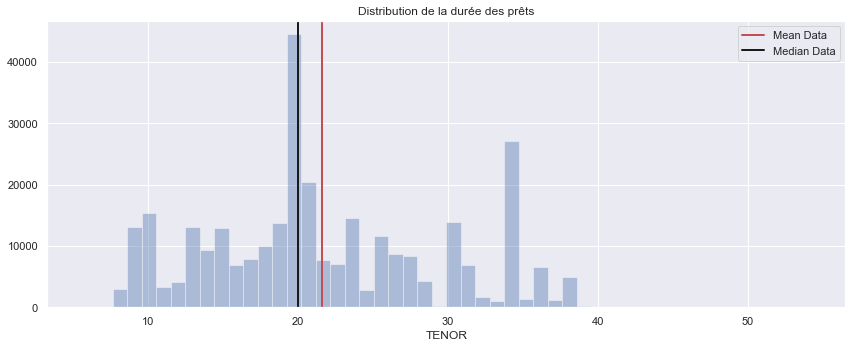

In [100]:
# Distribution de la durée des prêts

plt.figure(figsize=(12,5))
plt.title("Distribution de la durée des prêts")
ax = sns.distplot(df_explo["TENOR"], kde= False)
custom_lines = [plt.axvline(df_explo["TENOR"].mean(), color = 'r', linewidth = 2), 
               plt.axvline(df_explo["TENOR"].median(), color = 'k', linewidth = 2)]

plt.legend(custom_lines, ["Mean Data","Median Data"])

plt.tight_layout()
plt.show()

La majorité des prêts se retrouve autour de 20 ans, avec un certain nombres de prêts au dela de 30 ans. Il serait intéressant de regarder la distribution de ces prêts afin de voir s'il n'y a pas un lien avec les défauts de paiement.  
  
Passons ensuite à la création d'une variable faisant le ratio entre la durée d'emploi et l'age du client.

In [104]:
# Pour les valeurs positives de days employed (chomeurs ou retraités) je les laisse négatives 

data["Life_employed"] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

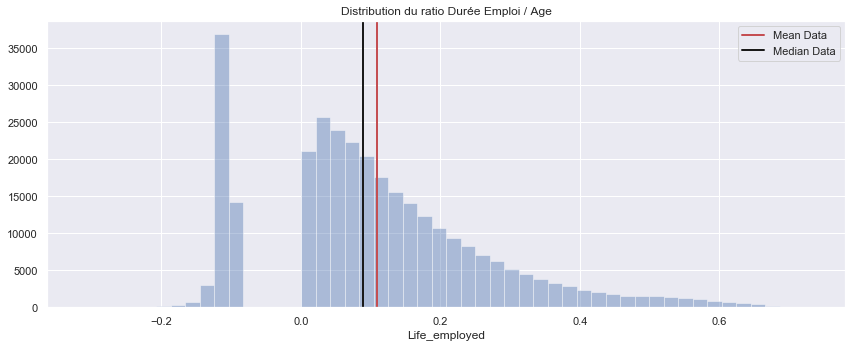

In [105]:
# Distribution du ratio

df_explo = data[data.train_test == "train"]
df_explo = pd.concat([df_explo, y_train], axis=1, sort=False)

plt.figure(figsize=(12,5))
plt.title("Distribution du ratio Durée Emploi / Age")
ax = sns.distplot(df_explo["Life_employed"], kde= False)
custom_lines = [plt.axvline(df_explo["Life_employed"].mean(), color = 'r', linewidth = 2), 
               plt.axvline(df_explo["Life_employed"].median(), color = 'k', linewidth = 2)]

plt.legend(custom_lines, ["Mean Data","Median Data"])

plt.tight_layout()
plt.show()

Enfin je vais créer une variable faisant le ratio entre la valeur du prêt et la valeur du bien financé.

In [106]:
data["LTV"] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']

df_explo = data[data.train_test == "train"]
df_explo = pd.concat([df_explo, y_train], axis=1, sort=False)

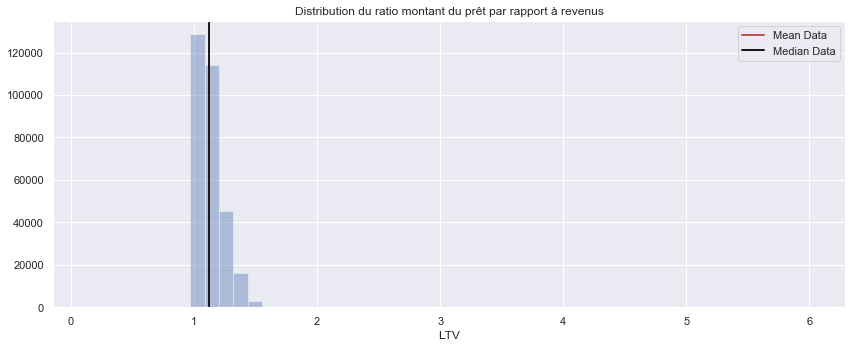

In [107]:
# Distribution du ratio LTV

plt.figure(figsize=(12,5))
plt.title("Distribution du ratio montant du prêt par rapport à revenus")
ax = sns.distplot(df_explo["LTV"], kde= False)
custom_lines = [plt.axvline(df_explo["LTV"].mean(), color = 'r', linewidth = 2), 
               plt.axvline(df_explo["LTV"].median(), color = 'k', linewidth = 2)]

plt.legend(custom_lines, ["Mean Data","Median Data"])

plt.tight_layout()
plt.show()

A nouveau il est surprenant de voir que des crédits sont accordés pour des biens dont la valeur est inférieure au montant du crédit

In [108]:
print("Il y a {}% des prêts dont la valeur dépasse celle du bien financé".format(
    round(100 * len(df_explo[df_explo["LTV"]>1]) / len(df_explo),0)))

Il y a 65.0% des prêts dont la valeur dépasse celle du bien financé


### Suppression des variables fortement corrélées

Afin de ne pas fausser les prédictions du modèle, il convient de supprimer les variables fortement corrélées entre elles.

In [109]:
# Identification des variables dont la corrélation dépasse 90%

corrmat = data.corr()
cols =[]
rows = []
for i in range(corrmat.shape[1]):
    for j in range(corrmat.shape[1]):
        if abs(corrmat.iloc[i,j])>0.9:
            if corrmat.columns[i] == corrmat.index[j]:
                pass
            else:
                cols.append(corrmat.columns[i])
                rows.append(corrmat.index[j])
print(cols)
print(rows)

['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'Life_employed']
['AMT_GOODS_PRICE', 'AMT_CREDIT', 'Life_employed', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DAYS_EMPLOYED']


In [110]:
# Pour chacune des variables, je regarde la corrélation avec la variable TARGET

data2 = data.merge(right=df[1][["SK_ID_CURR","TARGET"]], how='left', on='SK_ID_CURR')

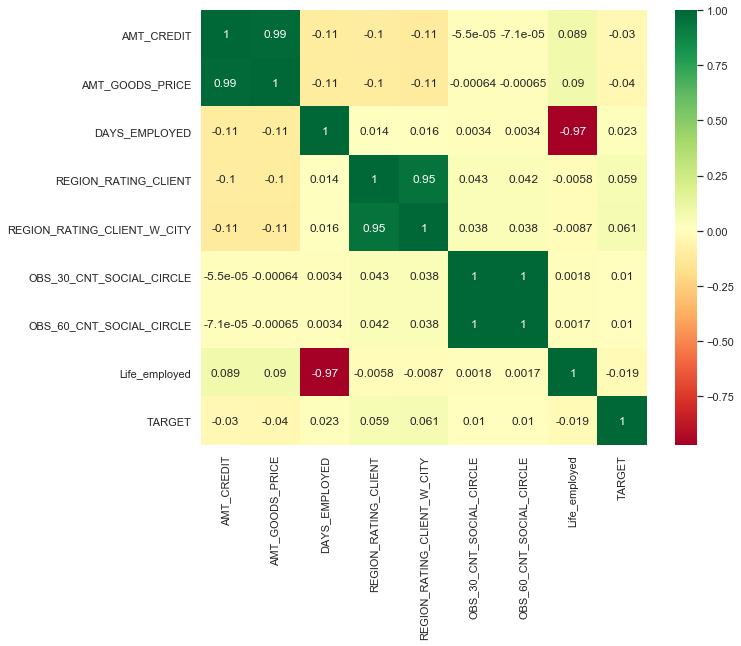

In [111]:
corrmat2 = data2[['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 
                 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 
                 'OBS_60_CNT_SOCIAL_CIRCLE', 'Life_employed','TARGET']].corr()

top_corr_features = corrmat2.index
plt.figure(figsize=(10,8))

#heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Je supprimerai les variables corrélées un peu plus tard car j'ai besoin de ces données pour le moment

In [112]:
# Export d'un df de test pour dashboard

data_test_clean = data[data.train_test == "test"]
data_test_clean = data_test_clean.drop("train_test", axis = 1)

data_test_clean.to_csv('data_test_clean.csv', index=False)

In [113]:
# Création et export d'un dataframe calculant la valeur moyenne des variables pour chaque valeur de la 
# variable Target pour utilisation future dans le Dashboard

data2 = data.merge(right=df[1][["SK_ID_CURR","TARGET"]], how='left', on='SK_ID_CURR')

df_moyennes = data2.groupby('TARGET').mean()

df_moyennes = df_moyennes.drop("SK_ID_CURR", axis = 1)

In [114]:
df_moyennes.to_csv('moyennes.csv', index=False)

### Transformation des variables catégorielles

In [115]:
# Fonction qui détermine les variables catégorielles et qui leur applique selon leur type LabelEncoder ou l'encodage
# get_dummies, et supprime enfin les variables catégorielles qui ont eu l'encodage get_dummies

def encode_categorical_features(df):
    feats_label = [col for col in list(df.columns) if (df[col].dtype == 'object') & (len(df[col].unique()) == 2)]
    feats_dummy = [col for col in list(df.columns) if (df[col].dtype == 'object') & (len(df[col].unique()) != 2)]
    
    for c1 in feats_dummy:
        df = pd.concat([df, pd.get_dummies(df[c1], prefix=c1, prefix_sep='_', drop_first = False)], axis=1)
    
    for c2 in feats_label:
        df[c2], _ = pd.factorize(df[c2])        
    
    df = df.drop(feats_dummy, axis = 1)
    
    return df


In [116]:
data.shape

(356255, 82)

In [117]:
# Encodage

data = encode_categorical_features(data)

<a id="section2"> </a>
# 2. Dataframes Bureau et Bureau_balance

<a id="section2.1"> </a>
## 2.A Dataframe Bureau

In [118]:
#df[2].info()

In [119]:
#df[2].head()

### Traitement des valeurs manquantes

In [120]:
#Observation des pourcentages de valeurs manquantes par colonnes ayant des valeurs manquantes

#nan_cols = [i for i in df[2].columns if df[2][i].isnull().any()]
#percent_missing = df[2][nan_cols].isna().sum() * 100 / len(df[2])
#plt.figure(figsize=(6, 6))
#percent_missing.sort_values().plot(kind='bar')
#plt.show()

In [121]:
# Analyse des 2 variables ayant plus de 60% de valeurs manquantes pour voir si on les supprime

#cols = ["AMT_CREDIT_MAX_OVERDUE", "AMT_ANNUITY"]

#for c in cols:
#    var_quant_desc(df[2], c, 'bureau.csv')

Pour la première variable,  je vais remplacer les valeurs manquantes par zéro car il s'agit d'un montant maximal d'overdue et que la distribution est composée pratiquement exclusivement par la valeur zéro.

Pour la seconde variable, vu le % de valeurs manquantes je préfère la supprimer.

In [122]:
#df[2]["AMT_CREDIT_MAX_OVERDUE"] = df[2]["AMT_CREDIT_MAX_OVERDUE"].fillna(0)

In [123]:
#df[2] = df[2].drop(["AMT_ANNUITY"], axis=1)

In [124]:
# Visualisation des autres variables ayant des valeurs manquantes
#for c in cols:
#    nan_cols.remove(c)

#for i in nan_cols:
#    var_quant_desc(df[2], i, 'bureau.csv')

Compte tenu de la spécificité de chaque variable, je vais les traiter séparemment

In [125]:
# Pour cette variable je vais remplacer par la médiane et ne vais pas éliminer les valeurs extrêmes qui représentent
# soit des crédits échus depuis longtemps soit des crédits loins d'être terminés

#var_quant_outlier("N", df[2], 'DAYS_CREDIT_ENDDATE', "median")
    

In [126]:
# Pour cette variable je vais utiliser une formule en me basant sur la typologie des crédits

#a = df[2][(df[2].CREDIT_ACTIVE == 'Closed') & (df[2].DAYS_ENDDATE_FACT.isna() == False)]['DAYS_ENDDATE_FACT'].mean()

#def fill_days_end(x):
#    if np.isnan(x['DAYS_ENDDATE_FACT']):
#        if x["CREDIT_ACTIVE"] == "Closed":
#            return a
#        else:
#            return 0
#    else:
#        return x['DAYS_ENDDATE_FACT']

#df[2]['DAYS_ENDDATE_FACT']=df[2].apply(lambda x : fill_days_end(x),axis=1)

In [127]:
# Enfin pour les trois variables restantes je vais remplacer par la valeur médiane sans supprimer les valeurs extrêmes

#col_end = ['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT']

#for i in col_end:
#    var_quant_outlier("N", df[2], i, "median")

### Analyse Exploratoire

In [128]:
# Tout d'abord je vais ajouter la variable Target au dataframe pour analyse
#data_target = df[1][['SK_ID_CURR', "TARGET"]]
#bureau_merge = pd.merge(df[2], data_target, on = 'SK_ID_CURR', how = 'left')

In [129]:
#len(bureau_merge)

In [130]:
# Analyse de la variable Credit_active

#plot_stats('CREDIT_ACTIVE', bureau_merge)

Most of the credits registered at the Credit Bureau are in the status Closed (~900K). On the second place are the Active credits ( a bit under 600K). Sold and Bad debt are just a few.

In the same time, as percent having TARGET = 1 from total number per category, clients with credits registered to the Credit Bureau with Bad debt have 20% default on the currrent applications.

Clients with credits Sold, Active and Closed have percent of TARGET == 1 (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with Closed credits.

That means the former registered credit history (as registered at Credit Bureau) is a strong predictor for the dafault credit, since the percent of applications defaulting with a history of Bad debt is twice as large as for Sold or Active and almost three times larger as for Closed.

In [131]:
# Analyse de la variable Type de Crédits

#plot_stats('CREDIT_TYPE', bureau_merge, True, True)

Majority of historical credits registered at the Credit Bureau are Consumer credit and Credit card. Smaller number of credits are Car loan, Mortgage and Microloan.

Looking now to the types of historical credits registered at the Credit Bureau, there are few types with a high percent of current credit defaults, as following:

Loan for the purchase of equipment - with over 20% current credits defaults;
Microloan - with over 20% current credits defaults;
Loan for working capital replenishement - with over 12% current credits defaults.

In [132]:
# Distribution des prêts en fonction de leur durée

#bureau_merge["YR_CREDIT"] = -bureau_merge["DAYS_CREDIT"] / 365

#plt.figure(figsize=(12,5))
#plt.title("Distribution prêts par durée")
#ax = sns.distplot(bureau_merge["YR_CREDIT"], kde= False)
#custom_lines = [plt.axvline(bureau_merge["YR_CREDIT"].mean(), color = 'r', linewidth = 2), 
 #              plt.axvline(bureau_merge["YR_CREDIT"].median(), color = 'k', linewidth = 2)]

#plt.legend(custom_lines, ["Mean Data","Median Data"])

#plt.tight_layout()
#plt.show()

The credit duration (in days) is ranging between less than 3000 days (with a local sadle around 2000 days) and with a increasing frequence for shorter number of days - and with a peak around 300 days (or less than one year).

### Feature Engineering

In [133]:
# Encodage des variables catégorielles

#df2_encoded = encode_categorical_features(df[2])

In [134]:
# Création d'un Df faisant la moyenne de toutes les variables du dataframe df[2]

#bureau_avg = df2_encoded.groupby('SK_ID_CURR').mean()
#bureau_avg['previous_loan_counts'] = df[2][['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
#bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]

In [135]:
# Création d'un Df comptant pour chaque ID le nombre de loans passés et fusion avec le DataFrame principal

bureau_count = pd.DataFrame()
bureau_count['previous_loan_counts'] = df[2][['SK_ID_BUREAU','SK_ID_CURR']].groupby(
    'SK_ID_CURR').count()['SK_ID_BUREAU']

data = data.merge(right=bureau_count.reset_index(), how='left', on='SK_ID_CURR') 

In [136]:
# Fusion avec le dataframe principal

#data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')

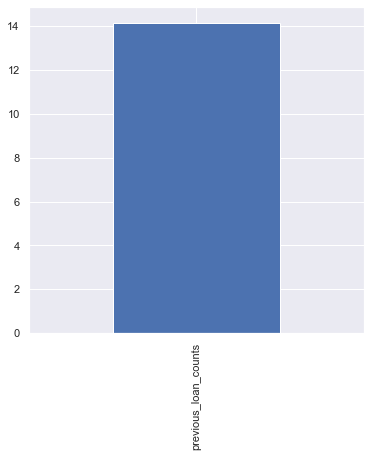

In [137]:
# Visualisation des valeurs manquantes post fusion

nan_cols = [i for i in data.columns if data[i].isnull().any()]
percent_missing = data[nan_cols].isna().sum() * 100 / len(data)
plt.figure(figsize=(6, 6))
percent_missing.sort_values().plot(kind='bar')
plt.show()

In [138]:
# Pour les entrées n'ayant pas eu de correspondances dans la table qui a fusionné, je remplace les valeurs manquantes
# par zéro
# Par ailleurs je supprime la colonne faisant référence à l'ID BUREAU

data = data.fillna(0)

#data = data.drop("b_SK_ID_BUREAU", axis = 1)

In [139]:
data.shape

(356255, 192)

<a id="section2.2"> </a>
## 2.B Dataframe Bureau_balance

In [140]:
#df[3].info()

In [141]:
# Observation de la distribution de la variable quantitative

#var_quant_desc(df[3],"MONTHS_BALANCE",'bureau_balance.csv')

In [142]:
# Observation de la variable catégorielle et de sa définition

#sns.set(style="whitegrid")
#plt.figure(figsize=(9,6))

#ax = sns.countplot(x="STATUS", 
#                   data=df[3],
#                  order = df[3].STATUS.value_counts().index)
#ax.set_title("Distribution de la variable Status")
#plt.show()

#print("Définition: {}".format(df[5][(df[5].Row == "STATUS") & 
#                                           (df[5].Table == 'bureau_balance.csv')].Description.values[0]))

Pour le moment je choisis de ne pas utiliser les données, disposant via le dataframe bureau des informations similaires 

<a id="section3"> </a>
# 3. Dataframe Previous Application

In [143]:
#df[8].info()

<a id="section3.1"> </a>
## 3.A Analyse des Valeurs manquantes

In [144]:
# Nombre de colonnes ayant des valeurs manquantes

#print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(df[8].isna().any()[lambda x: x]))

In [145]:
#Observation des pourcentages de valeurs manquantes par colonnes ayant des valeurs manquantes

#nan_cols = [i for i in df[8].columns if df[8][i].isnull().any()]
#percent_missing = df[8][nan_cols].isna().sum() * 100 / len(df[8])
#plt.figure(figsize=(10, 10))
#percent_missing.sort_values().plot(kind='bar')
#plt.show()

In [146]:
# Je commence par supprimer les 2 colonnes ayant plus de 90% de valeurs manquantes

#df_prev_app = df[8].drop(["RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED"], axis = 1)

In [147]:
# Observons la distribution des autres variables

#nan_cols = [i for i in df_prev_app.columns if df_prev_app[i].isnull().any()]
#percent_missing = df_prev_app[nan_cols].isna().sum() * 100 / len(df_prev_app)

#df_nan = percent_missing.sort_values(ascending = False).to_frame()

#X = df_prev_app[df_nan.index].dropna().values

#fig = plt.figure(figsize=(25, 30))

#for feat_idx in range(X.shape[1]):
#    ax = fig.add_subplot(17,3, (feat_idx+1))
#    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
#    ax.set_title(df_prev_app[df_nan.index].columns[feat_idx], fontsize=12)

#plt.show()

In [148]:
# Pour les variables catégorielles, je remplace les valeurs manquantes par le mode
# Pour les variables quantitatives, je les remplace par la valeur médiane

#cols_nan_categ = ["NAME_TYPE_SUITE", "PRODUCT_COMBINATION"]

#cols_nan_quant = list(set(nan_cols)-set(cols_nan_categ))

#for c in cols_nan_categ:
#    df_prev_app[c] = df_prev_app[c].fillna(df_prev_app[c].mode()[0])

#for d in cols_nan_quant:
#    df_prev_app[d] = df_prev_app[d].fillna(df_prev_app[d].median())

    
#print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(df_prev_app.isna().any()[lambda x: x]))

<a id="section3.2"> </a>
## 3.B Analyse Exploratoire

In [149]:
# Tout d'abord je vais ajouter la variable Target au dataframe pour analyse

#data_target = df[1][['SK_ID_CURR', "TARGET"]]
#df_prev_app = pd.merge(df_prev_app, data_target, on = 'SK_ID_CURR', how = 'left')

In [150]:
# Analyse de la variable Type de contrats (la variable ayant des données manquantes, je les remplace par le mode)

#df_prev_app.NAME_CONTRACT_TYPE.replace(
#    ['XNA'], 
#    [df_prev_app[df_prev_app.NAME_CONTRACT_TYPE!='XNA']['NAME_CONTRACT_TYPE'].mode()[0]], 
#    inplace=True)

#plot_stats('NAME_CONTRACT_TYPE', df_prev_app)

There are three types of contract in the previous application data: Cash loans, Consumer loans, Revolving loans. Cash loans and Consumer loans are almost the same number (~600K) whilst Revolving loans are ~150K.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from ~10% for Revolving loans, then ~ 9.5% for Cash loans and ~8% for Consumer loans.

In [151]:
# Analyse de la variable Contract Status

#plot_stats('NAME_CONTRACT_STATUS', df_prev_app)

Most previous applications contract statuses are Approved (850K), Canceled and Refused (240K). There are only  around 20K in status Unused offer.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are Refused (12%), followed by Canceled (9%), Unused offer (8%) and Approved (lowest percent of defaults in current applictions, with less than 8%).

In [152]:
# Analyse de la variable Payment Type (la variable ayant des données manquantes, je les remplace par le mode)

#df_prev_app.NAME_PAYMENT_TYPE.replace(
#    ['XNA'], 
#    [df_prev_app[df_prev_app.NAME_PAYMENT_TYPE!='XNA']['NAME_PAYMENT_TYPE'].mode()[0]], 
#    inplace=True)

#plot_stats('NAME_PAYMENT_TYPE', df_prev_app, True, True)

Most of the previous applications were paid with Cash through the bank (850K). Payments using Non-cash from your account or Cashless from the account of the employer are much rare. These three types of payments in previous applications results in allmost the same percent of defaults for current clients (8% each).

In [153]:
# Analyse de la variable Client Type (la variable ayant des données manquantes, je les remplace par le mode)

#df_prev_app.NAME_CLIENT_TYPE.replace(
#    ['XNA'], 
#    [df_prev_app[df_prev_app.NAME_CLIENT_TYPE!='XNA']['NAME_CLIENT_TYPE'].mode()[0]], 
#    inplace=True)

#plot_stats('NAME_CLIENT_TYPE', df_prev_app)

Most of the previous applications have client type Repeater (~1M), just over 200K are New and ~100K are Refreshed.

In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past New, Repeater and Refreshed, respectivelly.

In [154]:
#df_prev_app.info()

In [155]:
# Remplacement des valeurs manquantes XNA par le mode de la variable catégorielle

# Identification parmi les variables catégorielles de celle qui prennent la valeur XNA
#col_XNA = ["WEEKDAY_APPR_PROCESS_START", "FLAG_LAST_APPL_PER_CONTRACT","NAME_CASH_LOAN_PURPOSE",
#           "NAME_SELLER_INDUSTRY","NAME_YIELD_GROUP","PRODUCT_COMBINATION","CODE_REJECT_REASON",
#          "NAME_TYPE_SUITE","NAME_CLIENT_TYPE","NAME_GOODS_CATEGORY","NAME_PORTFOLIO","NAME_PRODUCT_TYPE",
#           "CHANNEL_TYPE"]

#liste=[]
#for c in col_XNA:
#    if "XNA" in df_prev_app[c].unique():
#        liste.append(c)

#for col in liste:
#    df_prev_app[col].replace(["XNA"], [df_prev_app[df_prev_app[col] != 'XNA'][col].mode()[0]],inplace=True)

<a id="section3.3"> </a>
## 3.C Feature engineering

In [156]:
# Encodage des variables catégorielles après suppression de la variable target

#df_prev_app = df_prev_app.drop("TARGET", axis=1)

#df_prev_app_encoded = encode_categorical_features(df_prev_app)

In [157]:
# Ajout du nombre de previous applications pour un SK_ID_CURR donné

#prev_apps_count = df_prev_app_encoded[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
#df_prev_app_encoded['prev_app_count'] = df_prev_app_encoded['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

In [158]:
# Création d'un Df comptant pour chaque ID le nombre de Previous Applications et fusion avec le DataFrame principal

prev_apps_count = pd.DataFrame()
prev_apps_count['prev_app_count'] = df[8][['SK_ID_CURR', 'SK_ID_PREV']].groupby(
    'SK_ID_CURR').count()['SK_ID_PREV']

data = data.merge(right=prev_apps_count.reset_index(), how='left', on='SK_ID_CURR') 

In [159]:
# Transformation du Df en prenant les valeurs moyennes des variables des previous applications

#df_prev_apps_avg = df_prev_app_encoded.groupby('SK_ID_CURR').mean()
#df_prev_apps_avg.columns = ['p_' + col for col in df_prev_apps_avg.columns]

In [160]:
# Fusion avec le dataframe principal

#data = data.merge(right=df_prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

In [161]:
# Pour les entrées n'ayant pas eu de correspondances dans la table qui a fusionné, je remplace les valeurs manquantes
# par zéro
# Je supprime aussi la variable faisant référence à un identifiant

data = data.fillna(0)

#data = data.drop(['p_SK_ID_PREV'], axis = 1)

In [162]:
data.shape

(356255, 193)

<a id="section4"> </a>
# 4. Dataframe instalments_payments et credit card balance

<a id="section4.1"> </a>
## 4.A Dataframe instalments_payments

In [163]:
#df[6].info()

### Traitement des valeurs manquantes

In [164]:
#Observation des pourcentages de valeurs manquantes par colonnes ayant des valeurs manquantes

#nan_cols = [i for i in df[6].columns if df[6][i].isnull().any()]
#percent_missing = df[6][nan_cols].isna().sum() * 100 / len(df[6])
#plt.figure(figsize=(6, 6))
#percent_missing.sort_values().plot(kind='bar')
#plt.show()

In [165]:
# Pour ces deux variables, je remplace les valeurs manquantes par la médiane

#for d in nan_cols:
#    df[6][d] = df[6][d].fillna(df[6][d].median())
    
#print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(df[6].isna().any()[lambda x: x]))

### Feature Engineering

In [166]:
# Ajout du nombre de previous installments pour un SK_ID_CURR donné

#cnt_inst = df[6][['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
#df[6]['prev_inst_count'] = df[6]['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

In [167]:
cnt_inst = pd.DataFrame()
cnt_inst['cnt_inst'] = df[6][['SK_ID_CURR', 'SK_ID_PREV']].groupby(
    'SK_ID_CURR').count()['SK_ID_PREV']

data = data.merge(right=cnt_inst.reset_index(), how='left', on='SK_ID_CURR') 

In [168]:
# Transformation du Df en prenant les valeurs moyennes des variables des previous installments

#avg_inst = df[6].groupby('SK_ID_CURR').mean()
#avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]

In [169]:
# Fusion avec le dataframe principal

#data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

In [170]:
# Visualisation des valeurs manquantes post fusion

#nan_cols = [i for i in data.columns if data[i].isnull().any()]
#percent_missing = data[nan_cols].isna().sum() * 100 / len(data)
#plt.figure(figsize=(6, 6))
#percent_missing.sort_values().plot(kind='bar')
#plt.show()

In [171]:
# Pour les entrées n'ayant pas eu de correspondances dans la table qui a fusionné, je remplace les valeurs manquantes
# par zéro
# Je supprime aussi la variable faisant référence à un identifiant

data = data.fillna(0)

#data = data.drop(['inst_SK_ID_PREV'], axis = 1)

In [172]:
data.shape

(356255, 194)

<a id="section4.2"> </a>
## 4.B Dataframe credit card balance

In [173]:
#df[4].info()

### Traitement des valeurs manquantes

In [174]:
#Observation des pourcentages de valeurs manquantes par colonnes ayant des valeurs manquantes

#nan_cols = [i for i in df[4].columns if df[4][i].isnull().any()]
#percent_missing = df[4][nan_cols].isna().sum() * 100 / len(df[4])
#plt.figure(figsize=(6, 6))
#percent_missing.sort_values().plot(kind='bar')
#plt.show()

In [175]:
# Pour ces variables, je remplace les valeurs manquantes par la mediane

#for d in nan_cols:
 #   df[4][d] = df[4][d].fillna(df[4][d].median())
    
#print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(df[6].isna().any()[lambda x: x]))

### Feature Engineering

In [176]:
# Encodage des variables catégorielles

#df_prev_ins = encode_categorical_features(df[4])

In [177]:
# Ajout du nombre de previous credit card balance pour un SK_ID_CURR donné

#nb_prevs = df_prev_ins[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
#df_prev_ins['prev_cc_bal'] = df_prev_ins['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

In [178]:
nb_prevs = pd.DataFrame()
nb_prevs['prev_cc_bal'] = df[4][['SK_ID_CURR', 'SK_ID_PREV']].groupby(
    'SK_ID_CURR').count()['SK_ID_PREV']

data = data.merge(right=nb_prevs.reset_index(), how='left', on='SK_ID_CURR') 

In [179]:
# Transformation du Df en prenant les valeurs moyennes des variables des previous credit card balance

#avg_cc_bal = df_prev_ins.groupby('SK_ID_CURR').mean()
#avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]

In [180]:
# Fusion avec le dataframe principal

#data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

In [181]:
# Valeurs manquantes post fusion

#nan_cols = [i for i in data.columns if data[i].isnull().any()]
#percent_missing = data[nan_cols].isna().sum() * 100 / len(data)
#plt.figure(figsize=(6, 6))
#percent_missing.sort_values().plot(kind='bar')
#plt.show()

In [182]:
# Pour les entrées n'ayant pas eu de correspondances dans la table qui a fusionné, je remplace les valeurs manquantes
# par zéro
# Je supprime aussi la variable faisant référence à un identifiant

data = data.fillna(0)

#data = data.drop(['cc_bal_SK_ID_PREV'], axis = 1)

In [183]:
data.shape

(356255, 195)

<a id="section5"> </a>
# 5. Dataframe POS CASH Balance

In [184]:
#df[7].info()

<a id="section5.1"> </a>
## 5.A Analyse des Valeurs manquantes

In [185]:
# Nombre de colonnes ayant des valeurs manquantes

#print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(df[7].isna().any()[lambda x: x]))

In [186]:
#Observation des pourcentages de valeurs manquantes par colonnes ayant des valeurs manquantes

#nan_cols = [i for i in df[7].columns if df[7][i].isnull().any()]
#percent_missing = df[7][nan_cols].isna().sum() * 100 / len(df[7])
#plt.figure(figsize=(10, 10))
#percent_missing.sort_values().plot(kind='bar')
#plt.show()

In [187]:
# Pour les 2 variables quantitatives, je remplace les valeurs manquantes par la valeur médiane

#nan_cols = [i for i in df[7].columns if df[7][i].isnull().any()]

#for c in nan_cols:
#    df[7][c] = df[7][c].fillna(df[7][c].median())
    
#print("Nombre de colonnes ayant au moins 1 valeur manquante:", len(df[7].isna().any()[lambda x: x]))

In [188]:
# Analyse de la variable Status de contrat (la variable ayant des données manquantes, je les remplace par le mode)

#df[7].NAME_CONTRACT_STATUS.replace(
#    ['XNA'], 
#    [df[7][df[7].NAME_CONTRACT_STATUS!='XNA']['NAME_CONTRACT_STATUS'].mode()[0]], 
#    inplace=True)

<a id="section5.2"> </a>
## 5.B Feature engineering

In [189]:
# Encodage de la variable catégorielle

#df_pos_cash_encoded = encode_categorical_features(df[7])

In [190]:
# Ajout du nombre de positions cash balance pour un SK_ID_CURR donné

#pcb_count = df_pos_cash_encoded[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
#df_pos_cash_encoded['pcb_count'] = df_pos_cash_encoded['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

In [191]:
pcb_count = pd.DataFrame()
pcb_count['pcb_count'] = df[7][['SK_ID_CURR', 'SK_ID_PREV']].groupby(
    'SK_ID_CURR').count()['SK_ID_PREV']

data = data.merge(right=pcb_count.reset_index(), how='left', on='SK_ID_CURR') 

In [192]:
# Transformation du Df en prenant les valeurs moyennes des variables des previous applications

#pcb_avg = df_pos_cash_encoded.groupby('SK_ID_CURR').mean()
#pcb_avg.columns = ['pcb_' + f_ for f_ in pcb_avg.columns]

In [193]:
# Fusion avec le dataframe principal

#data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')

In [194]:
# Valeurs manquantes post fusion

#nan_cols = [i for i in data.columns if data[i].isnull().any()]
#percent_missing = data[nan_cols].isna().sum() * 100 / len(data)
#plt.figure(figsize=(6, 6))
#percent_missing.sort_values().plot(kind='bar')
#plt.show()

In [195]:
# Pour les entrées n'ayant pas eu de correspondances dans la table qui a fusionné, je remplace les valeurs manquantes
# par zéro
# Je supprime aussi la variable faisant référence à un identifiant

data = data.fillna(0)

#data = data.drop(['pcb_SK_ID_PREV'], axis = 1)

<a id="section6"> </a>
# 6. Sauvegarde du fichier pour modélisation

In [196]:
# Ajout de la variable TARGET puis export CSV

data = data.merge(right=df[1][["SK_ID_CURR","TARGET"]], how='left', on='SK_ID_CURR')

In [197]:
# Je confirme que le jeu de données de test est celui pour lequel la valeur de Target est 0:
# suite à l'encodage, les valeurs test ont été codées à 0 et train à 1

data[data.TARGET.isna() == True].train_test.unique()

array([0])

In [198]:
data.to_csv('data_clean.csv', index=False)

In [199]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 197 entries, SK_ID_CURR to TARGET
dtypes: float64(35), int64(44), uint8(118)
memory usage: 257.5 MB


In [200]:
# Sauvegarde d'un fichier data_clean réduit en nombre de lignes pour utilisation dashboard

data_reduced = data.iloc[0:5000,:]
data_reduced.to_csv('data_clean_low.csv')